<h1> Wireline Log Analysis </h1> 

<h2> Part 1 </h2>
<h3> Clustering on Triple Combo Logs </h3>

We are going to do clustering on triple combo logs and compare the results with geologist's analysis

In [84]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [26]:
#loading the file

def load_LAS(filename):
    '''
    Load LAS file
    Args:
        filename: LAS file to load
    Return:
        las_df: LAS file in dataframe format
    '''
    
    #load the data
    las = lasio.read(filename)

    #convert to dataframe
    las_df = las.df()
    las_df = las_df.replace(-999.25, np.nan)

    #create a new column called 'DEPTH'
    las_df['DEPTH']=las_df.index
    return las_df


las_df_well_1 = load_LAS("./data/well_1.las")
las_df_well_1

Header section Version regexp=~V was not found.
Header section Parameter regexp=~P was not found.


,CALI,DTC,GR,LLD,LLS,MSFL,NPHI,PEF,POTA,RHOB,SGR,THOR,URAN,AZIMUTH,INC,EASTING,NORTHING,TVD,DEPTH
DEPTH,,,,,,,,,,,,,,,,,,,
1400.0988,NaN,78.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6060,1.6745,400943.1563,87039.0547,1399.7334,1400.0988
1400.2512,NaN,77.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6067,1.6753,400943.1563,87039.0469,1399.8857,1400.2512
1400.4036,NaN,76.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6074,1.6760,400943.1563,87039.0469,1400.0381,1400.4036
1400.5560,NaN,75.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6080,1.6768,400943.1563,87039.0391,1400.1904,1400.5560
1400.7084,NaN,72.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6087,1.6775,400943.1563,87039.0391,1400.3428,1400.7084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757.7816,NaN,77.81,NaN,NaN,NaN,NaN,0.2385,2.621,2.4,2.66,135.75,17.563,3.85,148.0049,0.2704,400946.0625,87032.6563,1757.3054,1757.7816
1757.9340,NaN,77.81,NaN,NaN,NaN,NaN,0.2385,2.621,2.4,2.66,135.75,17.563,3.85,148.0049,0.2704,400946.0625,87032.6563,1757.4578,1757.9340
1758.0864,NaN,77.81,NaN,NaN,NaN,NaN,0.2385,2.621,2.4,2.66,135.75,17.563,3.85,148.0049,0.2704,400946.0625,87032.6563,1757.6101,1758.0864


In [27]:
#select only depths that have complete curves
las_df_well_1 = las_df_well_1.dropna()
las_df_well_1

,CALI,DTC,GR,LLD,LLS,MSFL,NPHI,PEF,POTA,RHOB,SGR,THOR,URAN,AZIMUTH,INC,EASTING,NORTHING,TVD,DEPTH
DEPTH,,,,,,,,,,,,,,,,,,,
1487.7288,12.4378,76.81,119.3730,5.0465,4.6057,4.2766,0.3733,3.3767,3.4000,2.53,125.869,10.3179,4.1150,159.9219,2.2297,400944.1875,87036.5000,1487.3195,1487.7288
1487.8812,12.4228,76.69,118.9050,4.7519,4.4229,3.6847,0.3619,3.3475,3.4000,2.54,128.924,10.5556,4.2309,159.9514,2.2370,400944.1875,87036.4922,1487.4718,1487.8812
1488.0336,12.4752,78.75,115.5210,4.4015,4.1144,4.8480,0.3636,3.2653,3.4045,2.54,126.191,10.2088,4.1058,159.9810,2.2444,400944.1875,87036.4922,1487.6240,1488.0336
1488.1860,12.3841,79.88,113.4710,4.2874,4.0418,4.7533,0.3513,3.2798,3.7958,2.53,133.917,10.2958,4.2836,160.0106,2.2518,400944.1875,87036.4844,1487.7764,1488.1860
1488.3384,12.3665,81.06,119.3750,4.0245,3.8622,3.3685,0.3460,3.3632,3.8998,2.53,136.002,10.2981,4.3744,160.0401,2.2592,400944.1875,87036.4766,1487.9286,1488.3384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740.8652,8.5168,83.00,106.5310,3.5122,3.4866,4.2308,0.2812,3.5513,3.0000,2.61,132.765,14.3849,3.8187,148.0049,0.2704,400946.0313,87032.7266,1740.3892,1740.8652
1741.0176,8.5268,82.00,106.8210,3.5838,3.5709,4.2920,0.2799,3.5422,3.0000,2.61,133.229,14.4892,3.7822,148.0049,0.2704,400946.0313,87032.7266,1740.5415,1741.0176
1741.1700,8.2754,81.00,103.8810,3.5194,3.5287,2.8878,0.2624,3.4832,3.0031,2.60,132.471,14.4279,3.6991,148.0049,0.2704,400946.0313,87032.7266,1740.6940,1741.1700


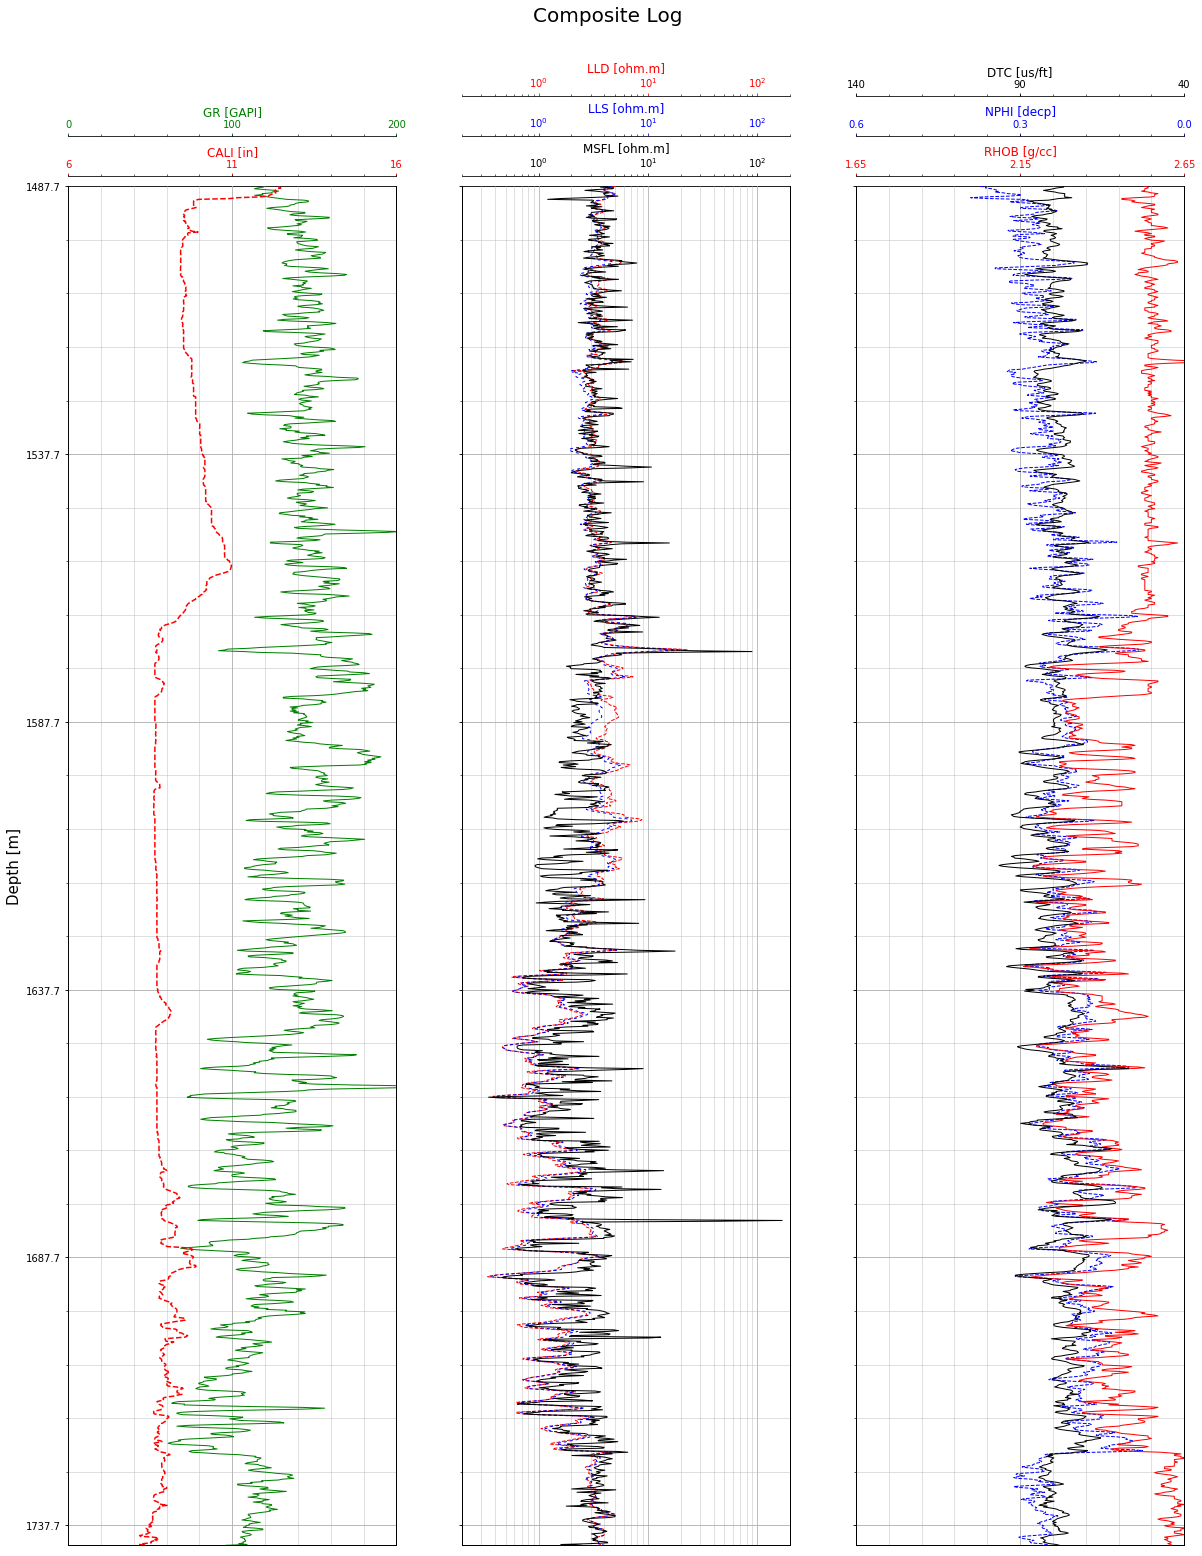

In [4]:
#visualize the log

def wireline_log_plotting(top,bottom,las):
    '''
    Plot wireline log
    
    Args:
        top: the top depth of the log
        bottom: the bottom depth of the log
        las: LASFile to plot
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,25),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.88)

    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False) 
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)


    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(las['GR'],las['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)

    #CALI
    ax_CALI=ax[0].twiny()
    ax_CALI.set_xlim(6,16)
    ax_CALI.set_xlabel('CALI [in]',color="Red",fontsize=12)
    ax_CALI.plot(las['CALI'],las['DEPTH'],'--',color="Red",label='CALI [in]')
    ax_CALI.tick_params(axis='x', colors='Red')
    ax_CALI.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(6, 17, 5)
    minor_ticks = np.arange(6, 17, 1)
    ax_CALI.set_xticks(major_ticks)
    ax_CALI.set_xticks(minor_ticks, minor=True)


#     #SGR
#     ax_SGR=ax[0].twiny()
#     ax_SGR.set_xlim(0,200)
#     ax_SGR.set_xlabel('SGR [GAPI]',color="Blue",fontsize=12)
#     ax_SGR.plot(las['SGR'],las['DEPTH'],color="Blue",label='SGR [GAPI]',linewidth=1)
#     ax_SGR.tick_params(axis='x', colors='Blue')
#     ax_SGR.spines['top'].set_position(('outward',90))
#     major_ticks = np.arange(0, 201, 100)
#     minor_ticks = np.arange(0, 201, 20)
#     ax_SGR.set_xticks(major_ticks)
#     ax_SGR.set_xticks(minor_ticks, minor=True)


    #Track 2: Resistivity

    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(las['LLD'],las['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

    #LLS
    ax_LLS=ax[1].twiny()
    ax_LLS.set_xscale('log')
    ax_LLS.set_xlim(0.2,200)
    ax_LLS.set_xlabel('LLS [ohm.m]',color="Blue",fontsize=12)
    ax_LLS.plot(las['LLS'],las['DEPTH'],'--',color="Blue",label='LLS [ohm.m]',dashes=[3,3],linewidth=1)
    ax_LLS.tick_params(axis='x', colors='Blue')
    ax_LLS.spines['top'].set_position(('outward',50))

    #MSFL
    ax_MSFL=ax[1].twiny()
    ax_MSFL.set_xscale('log')
    ax_MSFL.set_xlim(0.2,200)
    ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
    ax_MSFL.plot(las['MSFL'],las['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
    ax_MSFL.spines['top'].set_position(('outward',10))

    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(las['NPHI'],las['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(las['RHOB'],las['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(las['DTC'],las['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #PEF
#     ax_PEF=ax[2].twiny()
#     ax_PEF.set_xlim(0,20)
#     ax_PEF.set_xlabel('PEF []',color="Green",fontsize=12)
#     ax_PEF.plot(las['PEF'],las['DEPTH'],color="Green",label='PEF')
#     ax_PEF.tick_params(axis='x', colors='Green')
#     ax_PEF.spines['top'].set_position(('outward',140))
#     major_ticks = np.arange(0, 20, 10)
#     minor_ticks = np.arange(0, 20, 2)
#     ax_PEF.set_xticks(major_ticks)
#     ax_PEF.set_xticks(minor_ticks, minor=True);
    fig.savefig("wireline_log.jpg")

top = las_df_well_1['DEPTH'].min()
bottom = las_df_well_1['DEPTH'].max()

wireline_log_plotting(top,bottom,las_df_well_1)

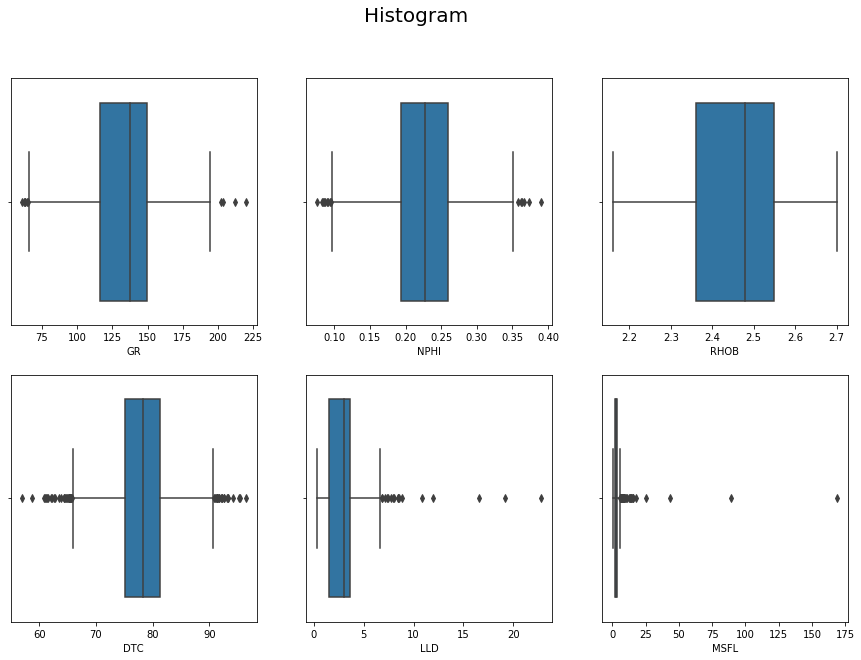

In [37]:
#draw boxplot of each main curve

def box_plot(df):
    
    ncols=3
    nrows=2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig.suptitle("Boxplot", fontsize=20)

    for axis in ax.flat:
        axis.set(xlabel='Value')
      
    sns.boxplot(df['GR'],ax=ax[0][0])
    sns.boxplot(df['NPHI'],ax=ax[0][1])
    sns.boxplot(df['RHOB'],ax=ax[0][2])
    sns.boxplot(df['DTC'],ax=ax[1][0])
    sns.boxplot(df['LLD'],ax=ax[1][1])
    sns.boxplot(df['MSFL'],ax=ax[1][2])

box_plot(las_df_well_1)

We can see that MSFL and LLD got a few outliers on the right side. <br>
We are going to take a deeper look into this

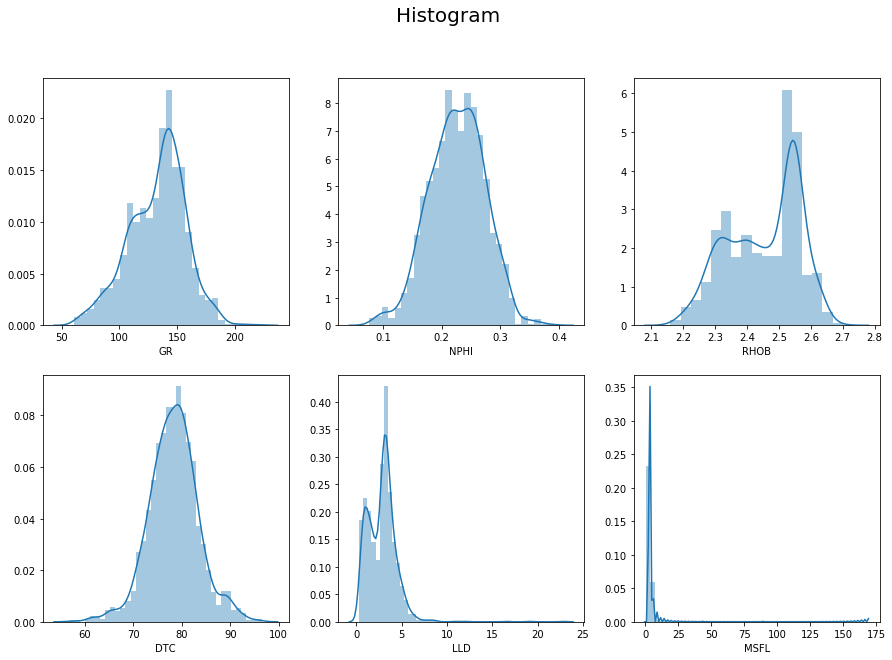

In [70]:
#histogram of each main curve

def histogram_plot(df):
    
    ncols=3
    nrows=2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig.suptitle("Histogram", fontsize=20)

    for axis in ax.flat:
        axis.set(xlabel='Value')
      
    sns.distplot(df['GR'],ax=ax[0][0],norm_hist=True)
    sns.distplot(df['NPHI'],ax=ax[0][1],norm_hist=True)
    sns.distplot(df['RHOB'],ax=ax[0][2],norm_hist=True)
    sns.distplot(df['DTC'],ax=ax[1][0],norm_hist=True)
    sns.distplot(df['LLD'],ax=ax[1][1],norm_hist=True)
    sns.distplot(df['MSFL'],ax=ax[1][2],norm_hist=True)

histogram_plot(las_df_well_1)

In [71]:
#Check the outliers in MSFL

las_df_well_1[las_df_well_1['MSFL']>75]

,CALI,DTC,GR,LLD,LLS,MSFL,NPHI,PEF,POTA,RHOB,SGR,THOR,URAN,AZIMUTH,INC,EASTING,NORTHING,TVD,DEPTH
DEPTH,,,,,,,,,,,,,,,,,,,
1574.5968,8.6801,66.00,106.6490,10.8908,9.1666,89.3277,0.1285,3.2291,4.4986,2.51,103.821,6.9006,0.7095,132.4959,0.6837,400945.2188,87033.7813,1574.1265,1574.5968
1680.8196,8.9148,64.75,79.0245,2.1735,2.4218,168.4890,0.1213,2.9129,2.3072,2.45,76.456,6.5157,1.8656,145.4583,0.4259,400945.8125,87033.0313,1680.3447,1680.8196


From the log plot, this might look like tight zones. <br>
We are going to remove them from our dataset 

In [72]:
#Remove the outliers

las_df_well_1_removed_outliers = las_df_well_1[las_df_well_1['MSFL']<75]
las_df_well_1_removed_outliers.index = pd.RangeIndex(len(las_df_well_1_removed_outliers.index))
las_df_well_1_removed_outliers

,CALI,DTC,GR,LLD,LLS,MSFL,NPHI,PEF,POTA,RHOB,SGR,THOR,URAN,AZIMUTH,INC,EASTING,NORTHING,TVD,DEPTH
0,12.4378,76.81,119.3730,5.0465,4.6057,4.2766,0.3733,3.3767,3.4000,2.53,125.869,10.3179,4.1150,159.9219,2.2297,400944.1875,87036.5000,1487.3195,1487.7288
1,12.4228,76.69,118.9050,4.7519,4.4229,3.6847,0.3619,3.3475,3.4000,2.54,128.924,10.5556,4.2309,159.9514,2.2370,400944.1875,87036.4922,1487.4718,1487.8812
2,12.4752,78.75,115.5210,4.4015,4.1144,4.8480,0.3636,3.2653,3.4045,2.54,126.191,10.2088,4.1058,159.9810,2.2444,400944.1875,87036.4922,1487.6240,1488.0336
3,12.3841,79.88,113.4710,4.2874,4.0418,4.7533,0.3513,3.2798,3.7958,2.53,133.917,10.2958,4.2836,160.0106,2.2518,400944.1875,87036.4844,1487.7764,1488.1860
4,12.3665,81.06,119.3750,4.0245,3.8622,3.3685,0.3460,3.3632,3.8998,2.53,136.002,10.2981,4.3744,160.0401,2.2592,400944.1875,87036.4766,1487.9286,1488.3384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,8.5168,83.00,106.5310,3.5122,3.4866,4.2308,0.2812,3.5513,3.0000,2.61,132.765,14.3849,3.8187,148.0049,0.2704,400946.0313,87032.7266,1740.3892,1740.8652
1660,8.5268,82.00,106.8210,3.5838,3.5709,4.2920,0.2799,3.5422,3.0000,2.61,133.229,14.4892,3.7822,148.0049,0.2704,400946.0313,87032.7266,1740.5415,1741.0176
1661,8.2754,81.00,103.8810,3.5194,3.5287,2.8878,0.2624,3.4832,3.0031,2.60,132.471,14.4279,3.6991,148.0049,0.2704,400946.0313,87032.7266,1740.6940,1741.1700
1662,8.1771,79.00,109.0080,3.6690,3.6544,1.5963,0.2517,3.4974,3.1954,2.61,137.562,14.7191,3.8674,148.0049,0.2704,400946.0313,87032.7266,1740.8463,1741.3224


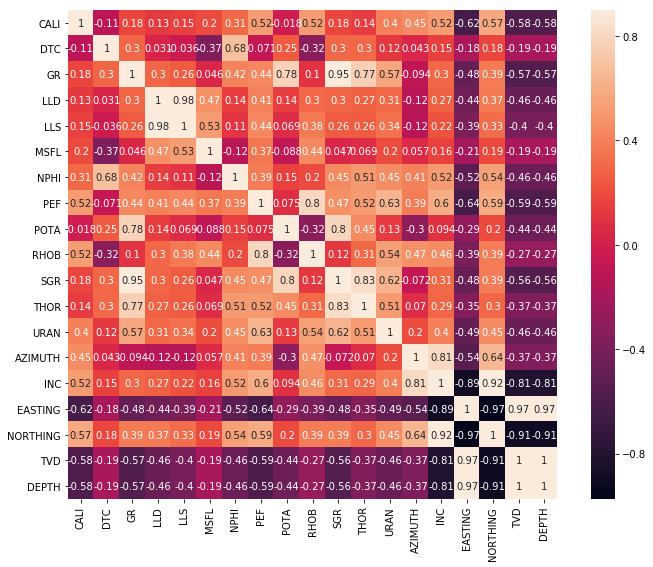

In [79]:
#Plotting heat correlation map between features to see collinearities

def plot_heatmap(las):
    '''
    Plot heatmap between features
    '''
    corr_matrix = las.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True)

plot_heatmap(las_df_well_1_removed_outliers)

From the correlation map we can see high correlated features: <br>
<b> LLD and LLS </b>: both tell resisitivity <br>
<b> RHOB and PEF </b>: both indicate lithology <br>
<b> GR and SGR </b>: both tell Gamma Ray <br>
We choose LLD, RHOB, and GR <br>
We also remove directional parameters: AZIMUTH, INC, EASTING, NORTHING, TVD <br>
We also remove spectral Gamma Ray parameters: POTA, URAN, THOR <br>

In [81]:
#for our analysis we will only select Triple Combo Curves

def get_triple_combo(df):
    '''
    Get only Triple Combo curves
    '''
    out = df[['DEPTH','GR','NPHI','RHOB','DTC','LLD','MSFL']]
    out.index = pd.RangeIndex(len(out.index))
    return out

las_df_well_1_TC = get_triple_combo(las_df_well_1_removed_outliers)
las_df_well_1_TC.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL
0,1487.7288,119.373,0.3733,2.53,76.81,5.0465,4.2766
1,1487.8812,118.905,0.3619,2.54,76.69,4.7519,3.6847
2,1488.0336,115.521,0.3636,2.54,78.75,4.4015,4.8480
3,1488.1860,113.471,0.3513,2.53,79.88,4.2874,4.7533
4,1488.3384,119.375,0.3460,2.53,81.06,4.0245,3.3685


We are going to scale the data using MinMaxScaler() considering the distribution of the data

In [92]:
def scaling_features(df_in):
    '''
    scale the features between 0 to 1
    Args:
        df_in: input dataframe to be scaled
    Returns:
        df_scaled: the new scaled dataframe
    '''

    scaler = MinMaxScaler()
    df_temp = df_in
    df_scaled = pd.DataFrame(scaler.fit_transform(df_in), columns=df_in.columns)
    df_scaled['DEPTH'] = df_temp['DEPTH']
    return df_scaled

df_scaled_well_1 = scaling_features(las_df_well_1_TC)
df_scaled_well_1.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL
0,1487.7288,0.368534,0.945894,0.685185,0.503038,0.209441,0.091927
1,1487.8812,0.365587,0.909612,0.703704,0.500000,0.196323,0.078074
2,1488.0336,0.344279,0.915022,0.703704,0.552152,0.180721,0.105300
3,1488.1860,0.331371,0.875875,0.685185,0.580759,0.175640,0.103084
4,1488.3384,0.368546,0.859007,0.685185,0.610633,0.163934,0.070674


First, we are going to do clustering with Triple Combo curves.

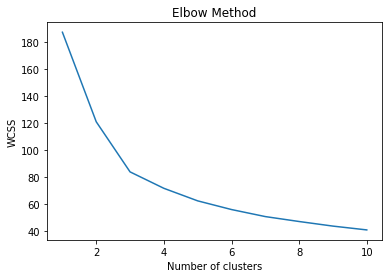

In [91]:
#find the optimum number of clusters using WCSS Elbow Method
#we remove depth from clustering

def find_K(df):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df.drop(['DEPTH'],axis=1))
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
find_K(df_scaled_well_1)

We will take K=3 based on above figure

In [93]:
def clustering(df,n_clusters):
    #run the K-means clustering

    kmeans = KMeans(n_clusters=n_clusters)
    k_means = kmeans.fit(df.drop(['DEPTH'],axis=1))
    labels = k_means.labels_

    #save the clustering results in the new column
    df['cluster']=k_means.labels_
    return df
    
df_scaled_well_1 = clustering(df_scaled_well_1,n_clusters=3)
df_scaled_well_1.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster
0,1487.7288,0.368534,0.945894,0.685185,0.503038,0.209441,0.091927,1
1,1487.8812,0.365587,0.909612,0.703704,0.500000,0.196323,0.078074,1
2,1488.0336,0.344279,0.915022,0.703704,0.552152,0.180721,0.105300,1
3,1488.1860,0.331371,0.875875,0.685185,0.580759,0.175640,0.103084,1
4,1488.3384,0.368546,0.859007,0.685185,0.610633,0.163934,0.070674,1


Now, we want to load facies classified by geologist

In [95]:
#load the facies data from geologist
df_facies = pd.read_csv('./data/well_1_facies.csv')
df_facies.head()

,Top Depth (mBRT),Bottom Depth (mBRT),Facies
0,1565.0,1577.5,2
1,1577.5,1580.0,1
2,1580.0,1584.0,2
3,1584.0,1591.0,3
4,1591.0,1596.0,1


In [97]:
#Add cluster column to the unscaled dataframe
las_df_well_1_TC['cluster'] = df_scaled_well_1['cluster']
las_df_well_1_TC.head()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster
0,1487.7288,119.373,0.3733,2.53,76.81,5.0465,4.2766,1
1,1487.8812,118.905,0.3619,2.54,76.69,4.7519,3.6847,1
2,1488.0336,115.521,0.3636,2.54,78.75,4.4015,4.8480,1
3,1488.1860,113.471,0.3513,2.53,79.88,4.2874,4.7533,1
4,1488.3384,119.375,0.3460,2.53,81.06,4.0245,3.3685,1


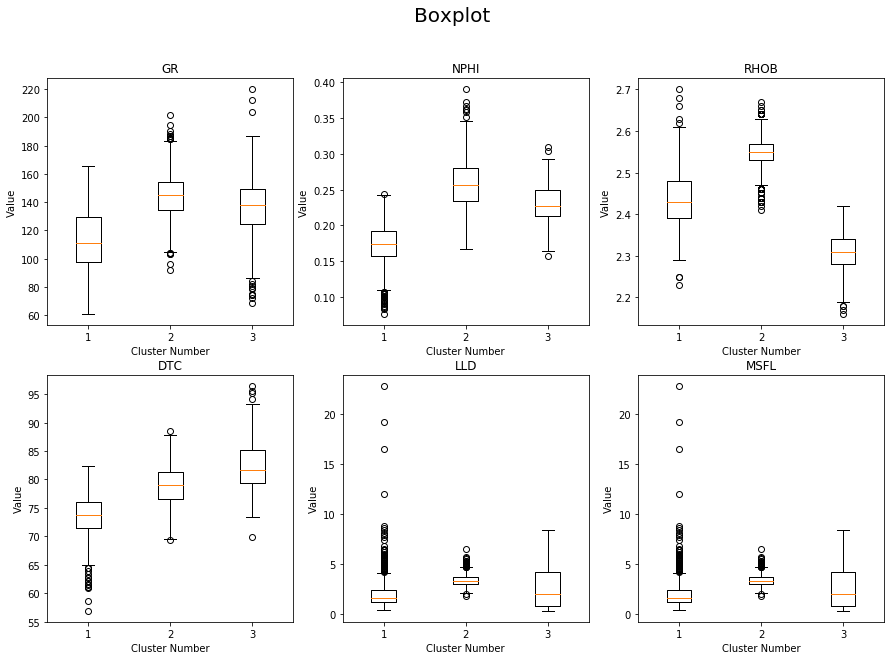

In [100]:
def cluster_boxplot(df,n_clusters):
    #boxplot of each cluster

    ncols=3
    nrows=2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig.suptitle("Boxplot", fontsize=20)
    # fig.subplots_adjust(top=0.88)

    for axis in ax.flat:
        axis.set(xlabel='Cluster Number', ylabel="Value")

    data_to_plot_1=[]
    data_to_plot_2=[]
    data_to_plot_3=[]
    data_to_plot_4=[]
    data_to_plot_5=[]


    for i in range(n_clusters):
        data_to_plot_1.append(df['GR'].loc[df['cluster']==i])
        data_to_plot_2.append(df['NPHI'].loc[df['cluster']==i])
        data_to_plot_3.append(df['RHOB'].loc[df['cluster']==i])
        data_to_plot_4.append(df['DTC'].loc[df['cluster']==i])
        data_to_plot_5.append(df['LLD'].loc[df['cluster']==i])


    # Create the boxplot
    ax[0][0].boxplot(data_to_plot_1)
    ax[0][0].set_title("GR")

    ax[0][1].boxplot(data_to_plot_2)
    ax[0][1].set_title("NPHI")

    ax[0][2].boxplot(data_to_plot_3)
    ax[0][2].set_title("RHOB")

    ax[1][0].boxplot(data_to_plot_4)
    ax[1][0].set_title("DTC")

    ax[1][1].boxplot(data_to_plot_5)
    ax[1][1].set_title("LLD");
    
    ax[1][2].boxplot(data_to_plot_5)
    ax[1][2].set_title("MSFL");

cluster_boxplot(las_df_well_1_TC,3)

Let's compare clustering results with facies identified by geologist

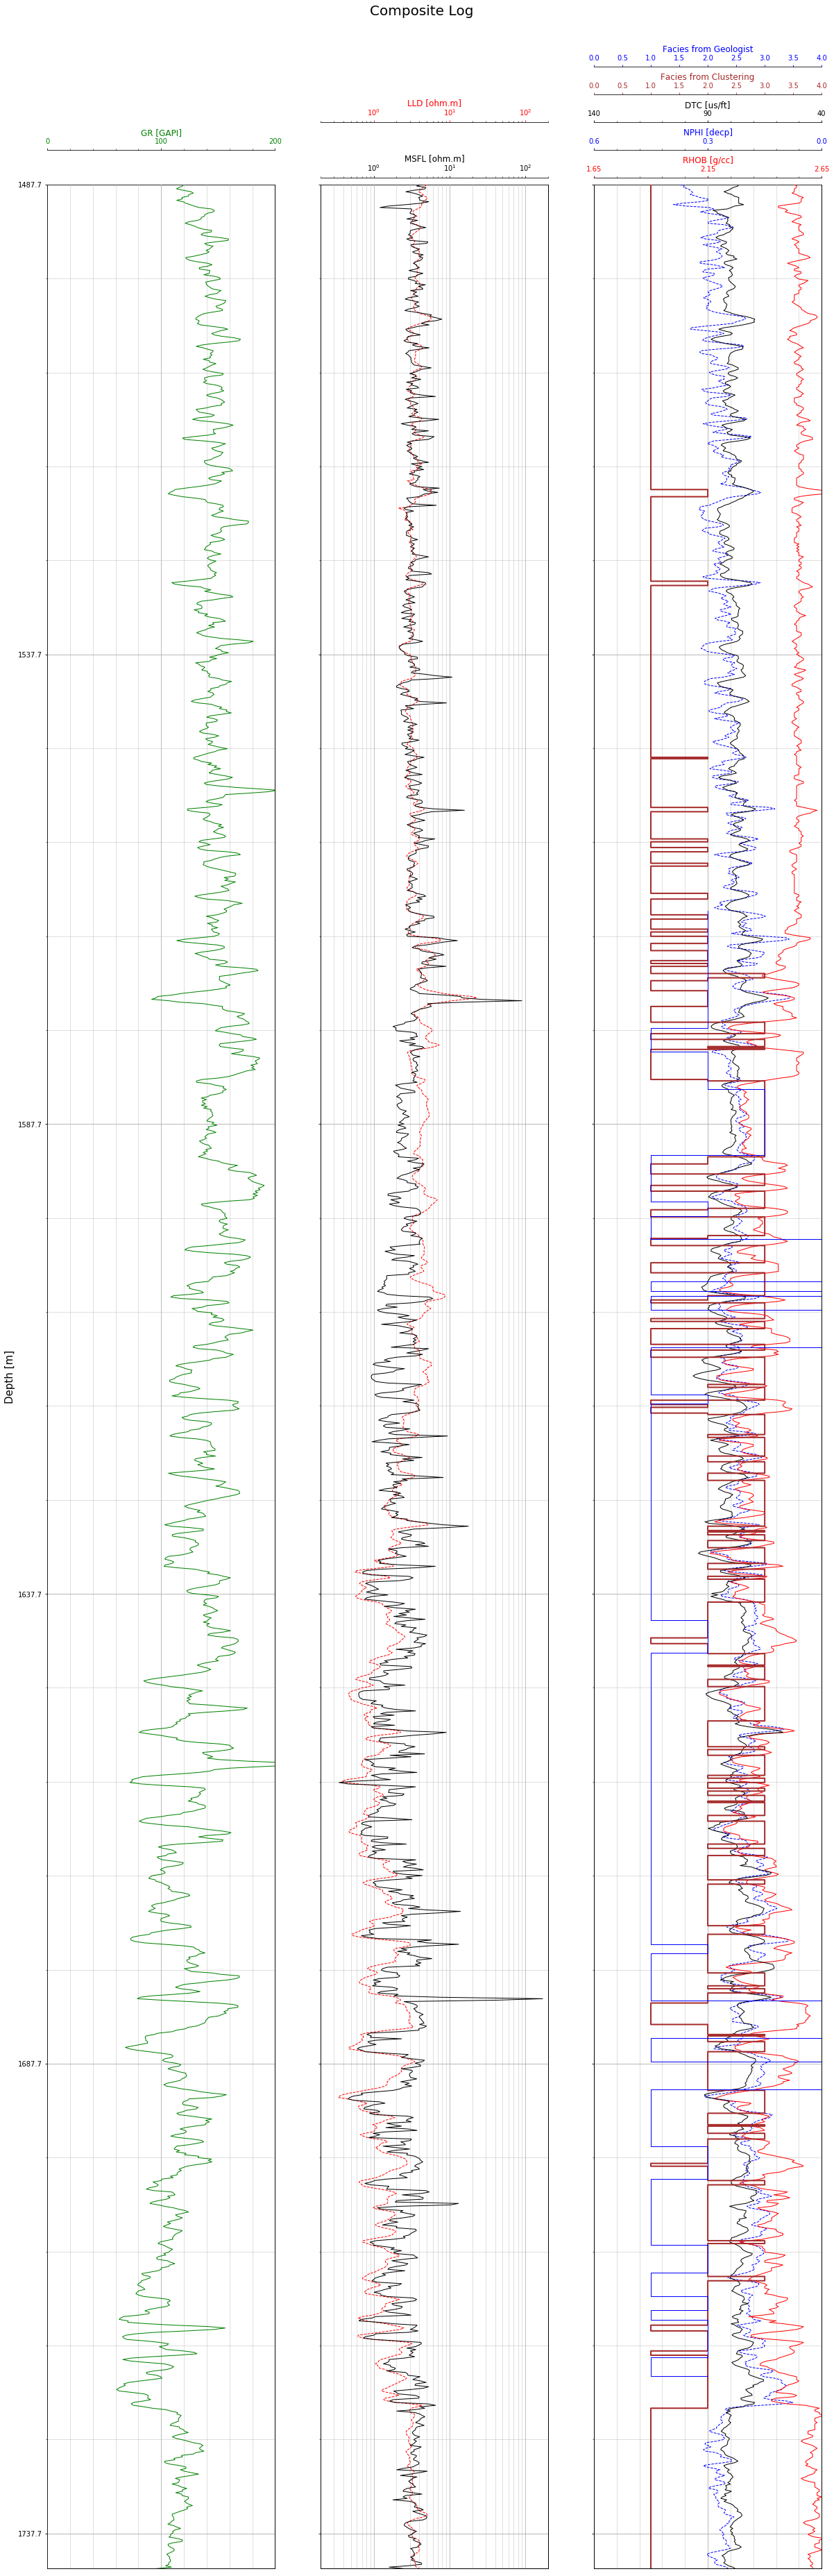

In [123]:
def plot_facies(df,df_facies):
    '''
    Plot facies identified by geologist compared with clustering results
    '''
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.92)

    top = df['DEPTH'].min()
    bottom = df['DEPTH'].max()
    
    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False) 
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(df['GR'],df['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)


    #Track 2: Resistivity
    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(df['LLD'],df['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

    #MSFL
    ax_MSFL=ax[1].twiny()
    ax_MSFL.set_xscale('log')
    ax_MSFL.set_xlim(0.2,200)
    ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
    ax_MSFL.plot(df['MSFL'],df['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
    ax_MSFL.spines['top'].set_position(('outward',10))

    
    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #FACIES FROM CLUSTERING
    ax_fc=ax[2].twiny()
    ax_fc.set_xlim(0,4)
    ax_fc.set_xlabel('Facies from Clustering',color="Brown",fontsize=12)
    ax_fc.step(df['cluster']+1,df['DEPTH'],color="Brown",label='Cluster',linewidth=2)
    ax_fc.tick_params(axis='x', colors='Brown')
    ax_fc.spines['top'].set_position(('outward',130))

    #FACIES FROM GEOLOGIST
    ax_fc2=ax[2].twiny()
    ax_fc2.set_xlim(0,4)
    ax_fc2.set_xlabel('Facies from Geologist',color="Blue",fontsize=12)
    ax_fc2.step(df_facies['Facies'],df_facies['Top Depth (mBRT)'],color="Blue",label='Facies',linewidth=1)
    ax_fc2.tick_params(axis='x', colors='Blue')
    ax_fc2.spines['top'].set_position(('outward',170))

plot_facies(las_df_well_1_TC,df_facies)

In [101]:
#save the dataframes
las_df_well_1_TC.to_csv('las_df_well_1_TC.csv')
df_scaled_well_1.to_csv('df_scaled_well_1.csv')

For plotting, notice that we add +1 on the clustering results just because the results span from 0 to 2 while we want to plot it as 1 to 3 (to match boxplot also)

We might suspect that cluster 2 and 3 from the plot and boxplot might indicate reservoir zones with low RHOB and low NPHI

<h2> PART 2 </h2>
<h3> Predict Porosity and Permeability from Log Curves </h3>

We are going to train the log curves against core porosity and permeability

In [102]:
#load RCAL data

df_rcal_well_1 = pd.read_csv('./data/well_1_rcal.csv')
df_rcal_well_1

,DEPTH (m),HE POR,KH,KV,Depth Shifted
0,1564.50,12.7,NaN,NaN,1566.00
1,1564.75,13.0,NaN,NaN,1566.25
2,1564.99,12.9,NaN,NaN,1566.49
3,1565.25,11.1,0.07,NaN,1566.75
4,1565.50,13.6,NaN,NaN,1567.00
...,...,...,...,...,...
344,1668.26,18.8,97.40,NaN,1669.76
345,1668.50,11.4,2.49,NaN,1670.00
346,1668.78,16.6,50.10,NaN,1670.28
347,1669.00,6.0,1.08,0.57,1670.50


We are going to combine the core porosity values with the triple combo logs. The problem is that the depth is not matched with triple combo logs. To overcome this problem, we will shift the core depth to match triple combo depth if the difference is < 10 cm

In [103]:
def shift_core_depth(df_in,df_rcal,tolerance=0.1,col_name='HE POR',depth_rcal='Depth Shifted',depth='DEPTH'):
    '''
    Create new column on Triple Combo dataframe for RCAL data
    Args:
        df_in: the main dataframe
        df_rcal: RCAL dataframe
        tolerance: depth tolerance to match RCAL depth with Log Depth (cm)
        col_name: column name of particular data in RCAL dataframe
        depth_rcal: column name of depth in RCAL dataframe
        depth: column name of depth in main dataframe
    '''
   
    df_in[col_name] = np.nan

    i=0
    for core_depth in df_rcal[depth_rcal]:
        while df_in[depth].iloc[i] < core_depth:
            i+=1

        if abs(df_in[depth].iloc[i] - core_depth) < 0.1:
            df_in[col_name].iloc[i] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]
        elif abs(df_in[depth].iloc[i+1] - core_depth) < 0.1:
            df_in[col_name].iloc[i+1] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]
    
    return df_in


las_df_well_1_TC_core = shift_core_depth(
                                            las_df_well_1_TC,
                                            df_rcal_well_1,
                                            col_name='HE POR',
                                            depth_rcal='Depth Shifted',
                                            depth='DEPTH'
                                        )

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\program files\python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [107]:
# Add core permeability data to the dataframe
las_df_well_1_TC_core = shift_core_depth(
                                            las_df_well_1_TC,
                                            df_rcal_well_1,
                                            col_name='KH',
                                            depth_rcal='Depth Shifted',
                                            depth='DEPTH'
                                        
)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\program files\python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [108]:
#drop N/A values

las_df_well_1_TC_core = las_df_well_1_TC_core.dropna()
las_df_well_1_TC_core.index = pd.RangeIndex(len(las_df_well_1_TC_core.index))
las_df_well_1_TC_core

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster,HE POR,KH
0,1566.8244,149.7280,0.1995,2.50,75.63,2.9470,2.9820,1,11.1,0.07
1,1567.5864,150.3340,0.2092,2.52,75.00,3.1111,2.7109,1,6.2,0.15
2,1569.5676,129.6380,0.1500,2.47,70.88,6.1829,7.2380,0,13.7,1.05
3,1570.3296,155.7130,0.2221,2.46,77.19,4.8306,5.4153,1,13.0,1.42
4,1572.0060,151.1430,0.1928,2.39,77.19,4.7360,4.2180,2,10.8,0.34
...,...,...,...,...,...,...,...,...,...,...
199,1669.2372,108.4070,0.1824,2.39,76.56,1.2997,2.3728,0,13.1,92.30
200,1669.5420,118.6780,0.1578,2.43,74.81,1.3173,2.0977,0,7.1,0.27
201,1669.8468,125.2220,0.1618,2.44,72.69,1.6297,3.3468,0,18.8,97.40
202,1670.3040,111.9650,0.1698,2.40,73.31,1.5921,2.4392,0,16.6,50.10


In [109]:
#save dataframe to csv
las_df_well_1_TC_core.to_csv('las_df_well_1_TC_core.csv')

In [145]:
#prepare data to be fed to Neural Network
#we are going to have 2 different datasets that we want to compare, 1 is scaled, another one is scaled

train_X_df_unscaled = las_df_well_1_TC_core.drop(['cluster','DEPTH','HE POR','MSFL','KH'],axis=1)
# train_Y_df_unscaled = las_df_well_1_TC_core[['HE POR','KH']]
train_Y_df_unscaled = las_df_well_1_TC_core[['HE POR']]


print(train_X_df_unscaled)
print(train_Y_df_unscaled)

           GR    NPHI  RHOB    DTC     LLD
0    149.7280  0.1995  2.50  75.63  2.9470
1    150.3340  0.2092  2.52  75.00  3.1111
2    129.6380  0.1500  2.47  70.88  6.1829
3    155.7130  0.2221  2.46  77.19  4.8306
4    151.1430  0.1928  2.39  77.19  4.7360
..        ...     ...   ...    ...     ...
199  108.4070  0.1824  2.39  76.56  1.2997
200  118.6780  0.1578  2.43  74.81  1.3173
201  125.2220  0.1618  2.44  72.69  1.6297
202  111.9650  0.1698  2.40  73.31  1.5921
203   94.4418  0.1424  2.46  69.69  1.5538

[204 rows x 5 columns]
     HE POR
0      11.1
1       6.2
2      13.7
3      13.0
4      10.8
..      ...
199    13.1
200     7.1
201    18.8
202    16.6
203    15.7

[204 rows x 1 columns]


In [113]:
#Prepare the scaled data
df_scaled_well_1['HE POR']=las_df_well_1_TC_core['HE POR']
df_scaled_well_1['KH']=las_df_well_1_TC_core['KH']
df_scaled_well_1 = df_scaled_well_1.dropna()
df_scaled_well_1

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster,HE POR,KH
0,1487.7288,0.368534,0.945894,0.685185,0.503038,0.209441,0.091927,1,11.1,0.07
1,1487.8812,0.365587,0.909612,0.703704,0.500000,0.196323,0.078074,1,6.2,0.15
2,1488.0336,0.344279,0.915022,0.703704,0.552152,0.180721,0.105300,1,13.7,1.05
3,1488.1860,0.331371,0.875875,0.685185,0.580759,0.175640,0.103084,1,13.0,1.42
4,1488.3384,0.368546,0.859007,0.685185,0.610633,0.163934,0.070674,1,10.8,0.34
...,...,...,...,...,...,...,...,...,...,...
199,1518.0564,0.635207,0.521642,0.740741,0.580759,0.157420,0.098913,1,13.1,92.30
200,1518.2088,0.640861,0.539147,0.740741,0.580759,0.121954,0.071991,1,7.1,0.27
201,1518.3612,0.582070,0.584978,0.759259,0.613924,0.127253,0.072675,1,18.8,97.40
202,1518.5136,0.597062,0.587206,0.759259,0.606076,0.129261,0.060680,1,16.6,50.10


In [146]:
#prepare data the scaled data

train_X_df_scaled = df_scaled_well_1.drop(['cluster','DEPTH','MSFL','KH','HE POR'],axis=1)
# train_Y_df_scaled = las_df_well_1_TC_core[['HE POR','KH']]
train_Y_df_scaled = df_scaled_well_1[['HE POR']]


print(train_X_df_scaled)
print(train_Y_df_scaled)

           GR      NPHI      RHOB       DTC       LLD
0    0.368534  0.945894  0.685185  0.503038  0.209441
1    0.365587  0.909612  0.703704  0.500000  0.196323
2    0.344279  0.915022  0.703704  0.552152  0.180721
3    0.331371  0.875875  0.685185  0.580759  0.175640
4    0.368546  0.859007  0.685185  0.610633  0.163934
..        ...       ...       ...       ...       ...
199  0.635207  0.521642  0.740741  0.580759  0.157420
200  0.640861  0.539147  0.740741  0.580759  0.121954
201  0.582070  0.584978  0.759259  0.613924  0.127253
202  0.597062  0.587206  0.759259  0.606076  0.129261
203  0.572273  0.575748  0.740741  0.568101  0.130922

[204 rows x 5 columns]
     HE POR
0      11.1
1       6.2
2      13.7
3      13.0
4      10.8
..      ...
199    13.1
200     7.1
201    18.8
202    16.6
203    15.7

[204 rows x 1 columns]


In [138]:
#Construct Neural Networks

def FCNN_tfkeras():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1))
                
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

We are going to train the model with the first 150 data and predict on the rest of the data in the same well

In [152]:
#train NN model

model_scaled = FCNN_tfkeras()

# es = EarlyStopping(monitor='val_loss',patience=5)

model_scaled.fit(
    train_X_df_scaled[:150].to_numpy(),
    train_Y_df_scaled[:150].to_numpy(),
    epochs=1000,
    shuffle=True,
    verbose=1,
    validation_split=0.2,
#     callbacks=[es]
)

Train on 120 samples, validate on 30 samples
Epoch 1/1000
120/120 [==============================] - 1s 4ms/sample - loss: 332.8801 - val_loss: 258.5907
Epoch 2/1000
120/120 [==============================] - 0s 91us/sample - loss: 326.8177 - val_loss: 253.2630
Epoch 3/1000
120/120 [==============================] - 0s 100us/sample - loss: 320.7824 - val_loss: 247.7560
Epoch 4/1000
120/120 [==============================] - 0s 100us/sample - loss: 314.6161 - val_loss: 242.3971
Epoch 5/1000
120/120 [==============================] - 0s 108us/sample - loss: 308.5021 - val_loss: 237.0076
Epoch 6/1000
120/120 [==============================] - 0s 150us/sample - loss: 302.2988 - val_loss: 231.2391
Epoch 7/1000
120/120 [==============================] - 0s 133us/sample - loss: 295.6547 - val_loss: 225.1559
Epoch 8/1000
120/120 [==============================] - 0s 133us/sample - loss: 288.5770 - val_loss: 218.6034
Epoch 9/1000
120/120 [==============================] - 0s 150us/sample - loss

120/120 [==============================] - 0s 100us/sample - loss: 28.4233 - val_loss: 25.3124
Epoch 76/1000
120/120 [==============================] - 0s 108us/sample - loss: 28.4157 - val_loss: 25.2271
Epoch 77/1000
120/120 [==============================] - 0s 100us/sample - loss: 28.4169 - val_loss: 25.2863
Epoch 78/1000
120/120 [==============================] - 0s 108us/sample - loss: 28.4086 - val_loss: 25.2558
Epoch 79/1000
120/120 [==============================] - 0s 100us/sample - loss: 28.4082 - val_loss: 25.2162
Epoch 80/1000
120/120 [==============================] - 0s 108us/sample - loss: 28.3962 - val_loss: 25.2016
Epoch 81/1000
120/120 [==============================] - 0s 175us/sample - loss: 28.4397 - val_loss: 25.3569
Epoch 82/1000
120/120 [==============================] - 0s 125us/sample - loss: 28.4065 - val_loss: 25.2126
Epoch 83/1000
120/120 [==============================] - 0s 108us/sample - loss: 28.3899 - val_loss: 25.3079
Epoch 84/1000
120/120 [==========

120/120 [==============================] - 0s 108us/sample - loss: 28.0712 - val_loss: 25.4855
Epoch 150/1000
120/120 [==============================] - 0s 116us/sample - loss: 28.0786 - val_loss: 25.7053
Epoch 151/1000
120/120 [==============================] - 0s 125us/sample - loss: 28.0390 - val_loss: 25.6032
Epoch 152/1000
120/120 [==============================] - 0s 133us/sample - loss: 28.0219 - val_loss: 25.6601
Epoch 153/1000
120/120 [==============================] - 0s 108us/sample - loss: 28.0283 - val_loss: 25.7345
Epoch 154/1000
120/120 [==============================] - 0s 91us/sample - loss: 28.0046 - val_loss: 25.5773
Epoch 155/1000
120/120 [==============================] - 0s 108us/sample - loss: 28.0157 - val_loss: 25.4760
Epoch 156/1000
120/120 [==============================] - 0s 100us/sample - loss: 28.0004 - val_loss: 25.5264
Epoch 157/1000
120/120 [==============================] - 0s 158us/sample - loss: 28.0030 - val_loss: 25.6790
Epoch 158/1000
120/120 [==

120/120 [==============================] - 0s 166us/sample - loss: 27.6116 - val_loss: 26.4118
Epoch 224/1000
120/120 [==============================] - 0s 133us/sample - loss: 27.6058 - val_loss: 26.2713
Epoch 225/1000
120/120 [==============================] - 0s 108us/sample - loss: 27.5947 - val_loss: 26.2432
Epoch 226/1000
120/120 [==============================] - 0s 108us/sample - loss: 27.5966 - val_loss: 26.2189
Epoch 227/1000
120/120 [==============================] - 0s 100us/sample - loss: 27.5997 - val_loss: 26.4382
Epoch 228/1000
120/120 [==============================] - 0s 100us/sample - loss: 27.6206 - val_loss: 26.6429
Epoch 229/1000
120/120 [==============================] - 0s 116us/sample - loss: 27.5736 - val_loss: 26.4119
Epoch 230/1000
120/120 [==============================] - 0s 141us/sample - loss: 27.6166 - val_loss: 26.4549
Epoch 231/1000
120/120 [==============================] - 0s 125us/sample - loss: 27.5642 - val_loss: 26.1970
Epoch 232/1000
120/120 [=

120/120 [==============================] - 0s 100us/sample - loss: 27.2030 - val_loss: 26.7685
Epoch 298/1000
120/120 [==============================] - 0s 100us/sample - loss: 27.1976 - val_loss: 26.6989
Epoch 299/1000
120/120 [==============================] - 0s 96us/sample - loss: 27.2086 - val_loss: 26.9296
Epoch 300/1000
120/120 [==============================] - 0s 100us/sample - loss: 27.1967 - val_loss: 26.7781
Epoch 301/1000
120/120 [==============================] - 0s 141us/sample - loss: 27.1830 - val_loss: 26.8647
Epoch 302/1000
120/120 [==============================] - 0s 175us/sample - loss: 27.1684 - val_loss: 27.0382
Epoch 303/1000
120/120 [==============================] - 0s 100us/sample - loss: 27.1917 - val_loss: 27.2988
Epoch 304/1000
120/120 [==============================] - 0s 100us/sample - loss: 27.1703 - val_loss: 27.0414
Epoch 305/1000
120/120 [==============================] - 0s 116us/sample - loss: 27.1702 - val_loss: 26.8776
Epoch 306/1000
120/120 [==

120/120 [==============================] - 0s 100us/sample - loss: 26.9667 - val_loss: 28.2425
Epoch 372/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.8828 - val_loss: 27.9441
Epoch 373/1000
120/120 [==============================] - 0s 158us/sample - loss: 26.8499 - val_loss: 28.0535
Epoch 374/1000
120/120 [==============================] - 0s 150us/sample - loss: 26.9150 - val_loss: 27.5524
Epoch 375/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.8763 - val_loss: 27.9171
Epoch 376/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.8226 - val_loss: 27.7629
Epoch 377/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.8218 - val_loss: 27.8061
Epoch 378/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.8472 - val_loss: 27.5913
Epoch 379/1000
120/120 [==============================] - 0s 125us/sample - loss: 26.8154 - val_loss: 27.7833
Epoch 380/1000
120/120 [=

120/120 [==============================] - 0s 100us/sample - loss: 26.5845 - val_loss: 28.7401
Epoch 446/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.5732 - val_loss: 28.6875
Epoch 447/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.6001 - val_loss: 28.8919
Epoch 448/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.5632 - val_loss: 28.5050
Epoch 449/1000
120/120 [==============================] - 0s 158us/sample - loss: 26.6676 - val_loss: 28.0232
Epoch 450/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.5640 - val_loss: 28.2414
Epoch 451/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.5471 - val_loss: 28.5849
Epoch 452/1000
120/120 [==============================] - 0s 91us/sample - loss: 26.5550 - val_loss: 28.9880
Epoch 453/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.5627 - val_loss: 29.1326
Epoch 454/1000
120/120 [==

120/120 [==============================] - 0s 108us/sample - loss: 26.3920 - val_loss: 29.5581
Epoch 520/1000
120/120 [==============================] - 0s 166us/sample - loss: 26.4149 - val_loss: 29.5531
Epoch 521/1000
120/120 [==============================] - 0s 125us/sample - loss: 26.3897 - val_loss: 29.3657
Epoch 522/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.4046 - val_loss: 28.9963
Epoch 523/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.4391 - val_loss: 28.6840
Epoch 524/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.4182 - val_loss: 29.3064
Epoch 525/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.3673 - val_loss: 29.4127
Epoch 526/1000
120/120 [==============================] - 0s 199us/sample - loss: 26.4539 - val_loss: 29.9989
Epoch 527/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.3914 - val_loss: 29.9187
Epoch 528/1000
120/120 [=

120/120 [==============================] - 0s 100us/sample - loss: 26.2670 - val_loss: 29.8422
Epoch 594/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.2791 - val_loss: 29.7732
Epoch 595/1000
120/120 [==============================] - 0s 191us/sample - loss: 26.2519 - val_loss: 29.4966
Epoch 596/1000
120/120 [==============================] - 0s 141us/sample - loss: 26.2856 - val_loss: 29.1785
Epoch 597/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.2773 - val_loss: 29.5258
Epoch 598/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.3140 - val_loss: 29.6168
Epoch 599/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.2982 - val_loss: 30.1632
Epoch 600/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.2643 - val_loss: 30.2350
Epoch 601/1000
120/120 [==============================] - 0s 150us/sample - loss: 26.2594 - val_loss: 30.3192
Epoch 602/1000
120/120 [=

120/120 [==============================] - 0s 133us/sample - loss: 26.2670 - val_loss: 30.2563
Epoch 668/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.1974 - val_loss: 30.2863
Epoch 669/1000
120/120 [==============================] - 0s 125us/sample - loss: 26.1946 - val_loss: 30.2240
Epoch 670/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.2171 - val_loss: 29.8192
Epoch 671/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.1918 - val_loss: 29.8463
Epoch 672/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.1939 - val_loss: 29.9329
Epoch 673/1000
120/120 [==============================] - 0s 119us/sample - loss: 26.1802 - val_loss: 30.2704
Epoch 674/1000
120/120 [==============================] - 0s 175us/sample - loss: 26.1965 - val_loss: 30.7309
Epoch 675/1000
120/120 [==============================] - 0s 125us/sample - loss: 26.2272 - val_loss: 30.8717
Epoch 676/1000
120/120 [=

120/120 [==============================] - 0s 108us/sample - loss: 26.1509 - val_loss: 30.0452
Epoch 742/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.1414 - val_loss: 30.3448
Epoch 743/1000
120/120 [==============================] - 0s 150us/sample - loss: 26.1267 - val_loss: 30.5302
Epoch 744/1000
120/120 [==============================] - 0s 133us/sample - loss: 26.1656 - val_loss: 31.0738
Epoch 745/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.1329 - val_loss: 31.0677
Epoch 746/1000
120/120 [==============================] - 0s 91us/sample - loss: 26.1298 - val_loss: 30.8877
Epoch 747/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.2457 - val_loss: 30.0963
Epoch 748/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.1946 - val_loss: 30.0780
Epoch 749/1000
120/120 [==============================] - 0s 133us/sample - loss: 26.2767 - val_loss: 31.2564
Epoch 750/1000
120/120 [==

120/120 [==============================] - 0s 191us/sample - loss: 26.1014 - val_loss: 30.8902
Epoch 816/1000
120/120 [==============================] - 0s 158us/sample - loss: 26.1090 - val_loss: 30.9382
Epoch 817/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.1347 - val_loss: 30.5198
Epoch 818/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.1158 - val_loss: 31.0131
Epoch 819/1000
120/120 [==============================] - 0s 91us/sample - loss: 26.1444 - val_loss: 30.5738
Epoch 820/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.0926 - val_loss: 30.8158
Epoch 821/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.1318 - val_loss: 31.3761
Epoch 822/1000
120/120 [==============================] - 0s 125us/sample - loss: 26.0801 - val_loss: 31.1812
Epoch 823/1000
120/120 [==============================] - 0s 158us/sample - loss: 26.0875 - val_loss: 31.1434
Epoch 824/1000
120/120 [==

120/120 [==============================] - 0s 158us/sample - loss: 26.0536 - val_loss: 30.8401
Epoch 890/1000
120/120 [==============================] - 0s 125us/sample - loss: 26.0716 - val_loss: 31.4217
Epoch 891/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.0553 - val_loss: 31.3100
Epoch 892/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.0658 - val_loss: 31.5406
Epoch 893/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.0435 - val_loss: 31.4265
Epoch 894/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.0780 - val_loss: 31.1572
Epoch 895/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.0335 - val_loss: 31.0505
Epoch 896/1000
120/120 [==============================] - 0s 150us/sample - loss: 26.0448 - val_loss: 31.0236
Epoch 897/1000
120/120 [==============================] - 0s 150us/sample - loss: 26.0619 - val_loss: 30.7301
Epoch 898/1000
120/120 [=

120/120 [==============================] - 0s 108us/sample - loss: 26.0115 - val_loss: 31.3206
Epoch 964/1000
120/120 [==============================] - 0s 116us/sample - loss: 25.9890 - val_loss: 31.0777
Epoch 965/1000
120/120 [==============================] - 0s 100us/sample - loss: 25.9938 - val_loss: 30.9787
Epoch 966/1000
120/120 [==============================] - 0s 100us/sample - loss: 25.9890 - val_loss: 31.1154
Epoch 967/1000
120/120 [==============================] - 0s 150us/sample - loss: 25.9850 - val_loss: 31.2451
Epoch 968/1000
120/120 [==============================] - 0s 141us/sample - loss: 26.0336 - val_loss: 31.7694
Epoch 969/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.0202 - val_loss: 31.5921
Epoch 970/1000
120/120 [==============================] - 0s 108us/sample - loss: 26.1286 - val_loss: 30.7704
Epoch 971/1000
120/120 [==============================] - 0s 100us/sample - loss: 26.0210 - val_loss: 31.4445
Epoch 972/1000
120/120 [=

In [151]:
#train NN model

model_unscaled = FCNN_tfkeras()

# es = EarlyStopping(monitor='val_loss',patience=5)

model_unscaled.fit(
    train_X_df_unscaled[:150].to_numpy(),
    train_Y_df_unscaled[:150].to_numpy(),
    epochs=1000,
    shuffle=True,
    verbose=1,
    validation_split=0.2,
#     callbacks=[es]
)

Train on 120 samples, validate on 30 samples
Epoch 1/1000
120/120 [==============================] - 1s 5ms/sample - loss: 662.8026 - val_loss: 305.9803
Epoch 2/1000
120/120 [==============================] - 0s 158us/sample - loss: 294.8320 - val_loss: 91.4951
Epoch 3/1000
120/120 [==============================] - 0s 166us/sample - loss: 87.5456 - val_loss: 19.9764
Epoch 4/1000
120/120 [==============================] - 0s 142us/sample - loss: 27.9839 - val_loss: 34.7564
Epoch 5/1000
120/120 [==============================] - 0s 108us/sample - loss: 41.2784 - val_loss: 69.1256
Epoch 6/1000
120/120 [==============================] - 0s 191us/sample - loss: 58.9420 - val_loss: 73.1497
Epoch 7/1000
120/120 [==============================] - 0s 133us/sample - loss: 54.5697 - val_loss: 54.3303
Epoch 8/1000
120/120 [==============================] - 0s 125us/sample - loss: 38.8701 - val_loss: 32.2412
Epoch 9/1000
120/120 [==============================] - 0s 116us/sample - loss: 26.5375 - 

Epoch 76/1000
120/120 [==============================] - 0s 115us/sample - loss: 21.5665 - val_loss: 15.3996
Epoch 77/1000
120/120 [==============================] - 0s 100us/sample - loss: 21.6771 - val_loss: 15.2356
Epoch 78/1000
120/120 [==============================] - 0s 116us/sample - loss: 21.5744 - val_loss: 15.6656
Epoch 79/1000
120/120 [==============================] - 0s 116us/sample - loss: 21.5533 - val_loss: 16.5472
Epoch 80/1000
120/120 [==============================] - 0s 108us/sample - loss: 21.6988 - val_loss: 16.8616
Epoch 81/1000
120/120 [==============================] - 0s 100us/sample - loss: 21.5825 - val_loss: 15.6873
Epoch 82/1000
120/120 [==============================] - 0s 100us/sample - loss: 21.5779 - val_loss: 14.9671
Epoch 83/1000
120/120 [==============================] - 0s 100us/sample - loss: 21.5802 - val_loss: 15.4926
Epoch 84/1000
120/120 [==============================] - 0s 108us/sample - loss: 21.5253 - val_loss: 15.8077
Epoch 85/1000
120/1

120/120 [==============================] - 0s 100us/sample - loss: 21.0067 - val_loss: 16.3550
Epoch 151/1000
120/120 [==============================] - 0s 183us/sample - loss: 20.9939 - val_loss: 16.0237
Epoch 152/1000
120/120 [==============================] - 0s 125us/sample - loss: 21.0268 - val_loss: 16.2461
Epoch 153/1000
120/120 [==============================] - 0s 249us/sample - loss: 20.9813 - val_loss: 15.8160
Epoch 154/1000
120/120 [==============================] - 0s 133us/sample - loss: 21.0093 - val_loss: 14.7373
Epoch 155/1000
120/120 [==============================] - 0s 191us/sample - loss: 20.9927 - val_loss: 15.6260
Epoch 156/1000
120/120 [==============================] - 0s 158us/sample - loss: 21.0128 - val_loss: 16.8795
Epoch 157/1000
120/120 [==============================] - 0s 158us/sample - loss: 20.9583 - val_loss: 16.3059
Epoch 158/1000
120/120 [==============================] - 0s 183us/sample - loss: 20.9933 - val_loss: 15.2077
Epoch 159/1000
120/120 [=

120/120 [==============================] - 0s 125us/sample - loss: 20.7715 - val_loss: 15.5206
Epoch 225/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.7784 - val_loss: 17.6388
Epoch 226/1000
120/120 [==============================] - 0s 100us/sample - loss: 20.7293 - val_loss: 15.9258
Epoch 227/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.7305 - val_loss: 14.9285
Epoch 228/1000
120/120 [==============================] - 0s 116us/sample - loss: 20.7734 - val_loss: 16.0818
Epoch 229/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.9954 - val_loss: 17.1420
Epoch 230/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.5748 - val_loss: 15.1467
Epoch 231/1000
120/120 [==============================] - 0s 150us/sample - loss: 20.9501 - val_loss: 14.2483
Epoch 232/1000
120/120 [==============================] - 0s 141us/sample - loss: 21.2871 - val_loss: 17.4656
Epoch 233/1000
120/120 [=

Epoch 298/1000
120/120 [==============================] - 0s 125us/sample - loss: 20.7675 - val_loss: 17.1751
Epoch 299/1000
120/120 [==============================] - 0s 125us/sample - loss: 20.6573 - val_loss: 15.1727
Epoch 300/1000
120/120 [==============================] - 0s 150us/sample - loss: 20.7124 - val_loss: 16.1346
Epoch 301/1000
120/120 [==============================] - 0s 116us/sample - loss: 21.0759 - val_loss: 14.2580
Epoch 302/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.9432 - val_loss: 17.4552
Epoch 303/1000
120/120 [==============================] - 0s 133us/sample - loss: 20.7992 - val_loss: 16.0165
Epoch 304/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.3723 - val_loss: 13.3815
Epoch 305/1000
120/120 [==============================] - 0s 100us/sample - loss: 20.9748 - val_loss: 15.6509
Epoch 306/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.4433 - val_loss: 16.6954
Epoch 307/

120/120 [==============================] - 0s 108us/sample - loss: 20.7965 - val_loss: 13.7925
Epoch 373/1000
120/120 [==============================] - 0s 100us/sample - loss: 20.8809 - val_loss: 17.7424
Epoch 374/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.4869 - val_loss: 14.6920
Epoch 375/1000
120/120 [==============================] - 0s 199us/sample - loss: 20.4978 - val_loss: 15.1990
Epoch 376/1000
120/120 [==============================] - 0s 141us/sample - loss: 20.4866 - val_loss: 15.9045
Epoch 377/1000
120/120 [==============================] - 0s 91us/sample - loss: 20.4933 - val_loss: 14.3647
Epoch 378/1000
120/120 [==============================] - 0s 100us/sample - loss: 20.4192 - val_loss: 15.9224
Epoch 379/1000
120/120 [==============================] - 0s 112us/sample - loss: 21.0294 - val_loss: 18.6343
Epoch 380/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.6337 - val_loss: 13.3960
Epoch 381/1000
120/120 [==

120/120 [==============================] - 0s 108us/sample - loss: 20.4096 - val_loss: 19.6284
Epoch 447/1000
120/120 [==============================] - 0s 107us/sample - loss: 20.6341 - val_loss: 14.6470
Epoch 448/1000
120/120 [==============================] - 0s 100us/sample - loss: 20.3529 - val_loss: 13.2213
Epoch 449/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.4058 - val_loss: 15.5371
Epoch 450/1000
120/120 [==============================] - 0s 108us/sample - loss: 21.5674 - val_loss: 17.7437
Epoch 451/1000
120/120 [==============================] - 0s 133us/sample - loss: 19.7598 - val_loss: 13.0276
Epoch 452/1000
120/120 [==============================] - 0s 166us/sample - loss: 21.1964 - val_loss: 13.1680
Epoch 453/1000
120/120 [==============================] - 0s 167us/sample - loss: 20.1766 - val_loss: 16.8354
Epoch 454/1000
120/120 [==============================] - 0s 125us/sample - loss: 20.5357 - val_loss: 16.5047
Epoch 455/1000
120/120 [=

120/120 [==============================] - 0s 125us/sample - loss: 20.2803 - val_loss: 13.9911
Epoch 521/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.0780 - val_loss: 14.5631
Epoch 522/1000
120/120 [==============================] - 0s 133us/sample - loss: 20.0516 - val_loss: 15.6914
Epoch 523/1000
120/120 [==============================] - 0s 125us/sample - loss: 20.0454 - val_loss: 14.3192
Epoch 524/1000
120/120 [==============================] - 0s 100us/sample - loss: 20.4351 - val_loss: 13.2058
Epoch 525/1000
120/120 [==============================] - 0s 150us/sample - loss: 19.9657 - val_loss: 16.0267
Epoch 526/1000
120/120 [==============================] - 0s 141us/sample - loss: 20.2180 - val_loss: 14.8947
Epoch 527/1000
120/120 [==============================] - 0s 166us/sample - loss: 19.8217 - val_loss: 13.3242
Epoch 528/1000
120/120 [==============================] - 0s 175us/sample - loss: 20.2906 - val_loss: 13.9125
Epoch 529/1000
120/120 [=

120/120 [==============================] - 0s 125us/sample - loss: 20.1301 - val_loss: 15.2670
Epoch 595/1000
120/120 [==============================] - 0s 108us/sample - loss: 20.2551 - val_loss: 12.3544
Epoch 596/1000
120/120 [==============================] - 0s 125us/sample - loss: 19.8702 - val_loss: 16.4815
Epoch 597/1000
120/120 [==============================] - 0s 108us/sample - loss: 19.9753 - val_loss: 14.6553
Epoch 598/1000
120/120 [==============================] - 0s 116us/sample - loss: 19.5608 - val_loss: 13.0798
Epoch 599/1000
120/120 [==============================] - 0s 108us/sample - loss: 19.9466 - val_loss: 13.5695
Epoch 600/1000
120/120 [==============================] - 0s 133us/sample - loss: 20.4552 - val_loss: 16.7549
Epoch 601/1000
120/120 [==============================] - 0s 133us/sample - loss: 21.0667 - val_loss: 12.2507
Epoch 602/1000
120/120 [==============================] - 0s 141us/sample - loss: 20.2168 - val_loss: 16.4689
Epoch 603/1000
120/120 [=

Epoch 668/1000
120/120 [==============================] - 0s 121us/sample - loss: 19.9440 - val_loss: 14.5213
Epoch 669/1000
120/120 [==============================] - 0s 108us/sample - loss: 19.8884 - val_loss: 13.1707
Epoch 670/1000
120/120 [==============================] - 0s 108us/sample - loss: 19.4299 - val_loss: 13.4752
Epoch 671/1000
120/120 [==============================] - 0s 141us/sample - loss: 19.4014 - val_loss: 13.7410
Epoch 672/1000
120/120 [==============================] - 0s 116us/sample - loss: 19.4345 - val_loss: 14.3532
Epoch 673/1000
120/120 [==============================] - 0s 108us/sample - loss: 19.3356 - val_loss: 13.2555
Epoch 674/1000
120/120 [==============================] - 0s 133us/sample - loss: 19.3683 - val_loss: 12.7525
Epoch 675/1000
120/120 [==============================] - 0s 116us/sample - loss: 19.4646 - val_loss: 12.4454
Epoch 676/1000
120/120 [==============================] - 0s 166us/sample - loss: 19.2707 - val_loss: 14.7852
Epoch 677/

120/120 [==============================] - 0s 108us/sample - loss: 19.1868 - val_loss: 12.7971
Epoch 743/1000
120/120 [==============================] - 0s 133us/sample - loss: 19.5700 - val_loss: 13.4317
Epoch 744/1000
120/120 [==============================] - 0s 125us/sample - loss: 19.3697 - val_loss: 12.1419
Epoch 745/1000
120/120 [==============================] - 0s 100us/sample - loss: 18.9609 - val_loss: 15.0921
Epoch 746/1000
120/120 [==============================] - 0s 116us/sample - loss: 19.1042 - val_loss: 12.7736
Epoch 747/1000
120/120 [==============================] - 0s 125us/sample - loss: 19.7701 - val_loss: 11.9185
Epoch 748/1000
120/120 [==============================] - 0s 208us/sample - loss: 19.0971 - val_loss: 15.6842
Epoch 749/1000
120/120 [==============================] - 0s 125us/sample - loss: 20.2450 - val_loss: 11.9432
Epoch 750/1000
120/120 [==============================] - 0s 133us/sample - loss: 18.9866 - val_loss: 13.2028
Epoch 751/1000
120/120 [=

120/120 [==============================] - 0s 116us/sample - loss: 18.8386 - val_loss: 12.5235
Epoch 817/1000
120/120 [==============================] - 0s 166us/sample - loss: 18.9815 - val_loss: 12.7761
Epoch 818/1000
120/120 [==============================] - 0s 100us/sample - loss: 19.1005 - val_loss: 11.8028
Epoch 819/1000
120/120 [==============================] - 0s 100us/sample - loss: 18.4692 - val_loss: 13.5964
Epoch 820/1000
120/120 [==============================] - 0s 108us/sample - loss: 18.8516 - val_loss: 11.8244
Epoch 821/1000
120/120 [==============================] - 0s 166us/sample - loss: 18.7516 - val_loss: 12.6164
Epoch 822/1000
120/120 [==============================] - 0s 133us/sample - loss: 18.4834 - val_loss: 12.0331
Epoch 823/1000
120/120 [==============================] - 0s 133us/sample - loss: 18.6752 - val_loss: 12.0043
Epoch 824/1000
120/120 [==============================] - 0s 158us/sample - loss: 19.2141 - val_loss: 12.7557
Epoch 825/1000
120/120 [=

120/120 [==============================] - 0s 125us/sample - loss: 18.3877 - val_loss: 12.4068
Epoch 891/1000
120/120 [==============================] - 0s 125us/sample - loss: 18.4635 - val_loss: 12.1286
Epoch 892/1000
120/120 [==============================] - 0s 100us/sample - loss: 18.4833 - val_loss: 11.4030
Epoch 893/1000
120/120 [==============================] - 0s 108us/sample - loss: 18.1930 - val_loss: 12.9588
Epoch 894/1000
120/120 [==============================] - 0s 141us/sample - loss: 18.5410 - val_loss: 11.8429
Epoch 895/1000
120/120 [==============================] - 0s 125us/sample - loss: 18.1416 - val_loss: 11.6086
Epoch 896/1000
120/120 [==============================] - 0s 141us/sample - loss: 18.3186 - val_loss: 12.1661
Epoch 897/1000
120/120 [==============================] - 0s 125us/sample - loss: 18.5715 - val_loss: 11.8842
Epoch 898/1000
120/120 [==============================] - 0s 200us/sample - loss: 18.1169 - val_loss: 11.5686
Epoch 899/1000
120/120 [=

120/120 [==============================] - 0s 108us/sample - loss: 17.8389 - val_loss: 11.3554
Epoch 965/1000
120/120 [==============================] - 0s 208us/sample - loss: 17.8987 - val_loss: 11.9255
Epoch 966/1000
120/120 [==============================] - 0s 116us/sample - loss: 17.7627 - val_loss: 11.3479
Epoch 967/1000
120/120 [==============================] - 0s 108us/sample - loss: 18.0118 - val_loss: 11.2918
Epoch 968/1000
120/120 [==============================] - 0s 133us/sample - loss: 17.7723 - val_loss: 12.3413
Epoch 969/1000
120/120 [==============================] - 0s 108us/sample - loss: 18.3842 - val_loss: 11.5985
Epoch 970/1000
120/120 [==============================] - 0s 133us/sample - loss: 17.8024 - val_loss: 11.8481
Epoch 971/1000
120/120 [==============================] - 0s 158us/sample - loss: 17.8728 - val_loss: 11.2076
Epoch 972/1000
120/120 [==============================] - 0s 133us/sample - loss: 18.6689 - val_loss: 11.6060
Epoch 973/1000
120/120 [=

In [153]:
#do prediction on the rest of the data
model_unscaled.evaluate(train_X_df_unscaled[151:].to_numpy(),train_Y_df_unscaled[151:].to_numpy())

53/53 [==============================] - 0s 113us/sample - loss: 24.7766


24.776620433015644

In [154]:
#do prediction on the rest of the data
model_scaled.evaluate(train_X_df_scaled[151:].to_numpy(),train_Y_df_scaled[151:].to_numpy())

53/53 [==============================] - 0s 113us/sample - loss: 32.4618


32.461823877298606

In [ ]:
UNSCALED RESULTS IS BETTER

In [159]:
#saving model
# serialize model to JSON
model_json_scaled = model_scaled.to_json()
with open("model_scaled.json", "w") as json_file:
    json_file.write(model_json_scaled)
# serialize weights to HDF5
model_scaled.save_weights("model_weights_scaled.h5")
model_scaled.save("model_scaled.h5")
print("Saved model to disk")

Saved model to disk


In [160]:
#saving model
# serialize model to JSON
model_json_unscaled = model_unscaled.to_json()
with open("model_unscaled.json", "w") as json_file:
    json_file.write(model_json_unscaled)
# serialize weights to HDF5
model_unscaled.save_weights("model_weights_unscaled.h5")
model_unscaled.save("model_unscaled.h5")
print("Saved model to disk")

Saved model to disk


Plot the results

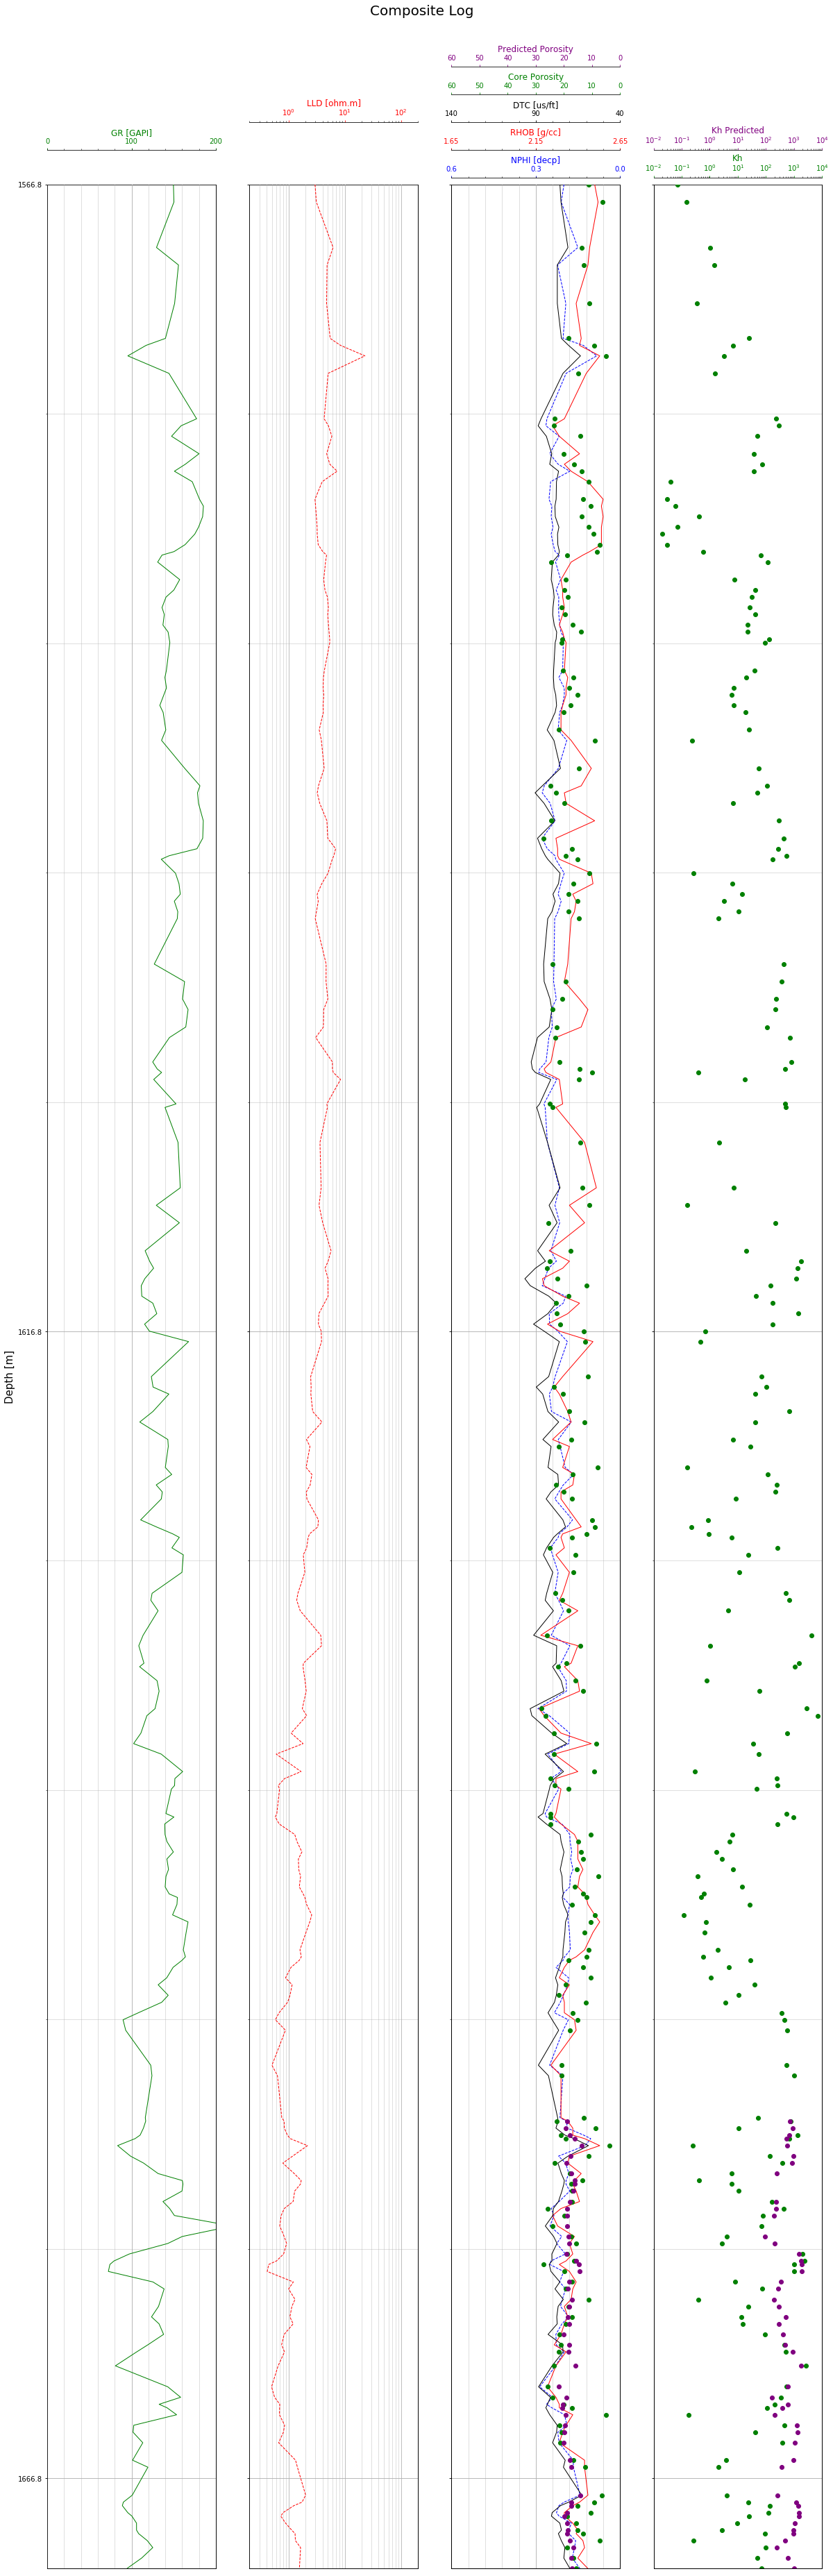

In [143]:
def plot_rcal(df,y_pred,depth_pred):
    '''
    Plot facies identified by geologist compared with clustering results
    '''
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,60),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.92)

    top = df['DEPTH'].min()
    bottom = df['DEPTH'].max()
    
    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False) 
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(df['GR'],df['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)


    #Track 2: Resistivity
    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(df['LLD'],df['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

#     #MSFL
#     ax_MSFL=ax[1].twiny()
#     ax_MSFL.set_xscale('log')
#     ax_MSFL.set_xlim(0.2,200)
#     ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
#     ax_MSFL.plot(df['MSFL'],df['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
#     ax_MSFL.spines['top'].set_position(('outward',10))

    
    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #core porosity
    ax_por=ax[2].twiny()
    ax_por.set_xlim(60,0)
    ax_por.set_xlabel('Core Porosity',color="Green",fontsize=12)
    ax_por.scatter(df['HE POR'],df['DEPTH'],color="Green",label='Core Porosity',linewidth=1)
    ax_por.tick_params(axis='x', colors='Green')
    ax_por.spines['top'].set_position(('outward',130))

    #prediction results
    ax_pred=ax[2].twiny()
    ax_pred.set_xlim(60,0)
    ax_pred.set_xlabel('Predicted Porosity',color="Purple",fontsize=12)
    ax_pred.scatter(y_pred[:,0],depth_pred[151:],color="Purple",label='Predicted Porosity',linewidth=1)
    ax_pred.tick_params(axis='x', colors='Purple')
    ax_pred.spines['top'].set_position(('outward',170))

    #KH
    ax_kh=ax[3].twiny()
    ax_kh.set_xscale('log')
    ax_kh.set_xlim(0.01,10000)
    ax_kh.set_xlabel('Kh',color="Green",fontsize=12)
    ax_kh.scatter(df['KH'],df['DEPTH'],color="Green",label='Kh',linewidth=1)
    ax_kh.tick_params(axis='x', colors='Green')
    ax_kh.spines['top'].set_position(('outward',10))

    #KH predicted
    ax_kh_pred=ax[3].twiny()
    ax_kh_pred.set_xscale('log')
    ax_kh_pred.set_xlim(0.01,10000)
    ax_kh_pred.set_xlabel('Kh Predicted',color="Purple",fontsize=12)
    ax_kh_pred.scatter(y_pred[:,1],depth_pred[151:],color="Purple",label='Kh Predicted',linewidth=1)
    ax_kh_pred.tick_params(axis='x', colors='Purple')
    ax_kh_pred.spines['top'].set_position(('outward',50))

plot_rcal(las_df_well_1_TC_core,y_pred,las_df_well_1_TC_core['DEPTH'])

<h1> Part 3 </h1>
<h2> Predict Porosity and Permeability of other wells in the same field </h2>

In [185]:
#load LAS data

las_df_well_2 = load_LAS("./data/well_2.las")
las_df_well_2

Header section Parameter regexp=~P was not found.


,CALI,DRHO,DTC,GR,LLD,LLS,MSFL,NPHI,RHOB,SP,AZIM,EASTING,INC,NORTHING,TVD,DEPTH
DEPTH,,,,,,,,,,,,,,,,
798.6139,NaN,NaN,174.4710,109.049,2.4615,1.5533,140.492,NaN,2.0012,-327.163,125.2955,401253.4375,43.0868,85595.0938,736.4166,798.6139
798.7663,NaN,NaN,172.9800,107.666,2.4923,1.5761,136.075,NaN,2.0055,-326.795,125.2947,401253.5625,43.0877,85595.0078,736.5627,798.7663
798.9187,NaN,NaN,171.5640,107.890,2.5163,1.5896,136.409,NaN,2.0096,-326.736,125.2944,401253.6250,43.0882,85594.9688,736.6357,798.9187
799.0711,NaN,NaN,169.0380,112.576,2.5545,1.6051,111.354,NaN,2.0171,-326.973,125.2936,401253.7188,43.0891,85594.8906,736.7818,799.0711
799.2235,NaN,NaN,168.3960,115.341,2.5597,1.6026,115.442,NaN,2.0190,-327.003,125.2933,401253.7813,43.0896,85594.8516,736.8549,799.2235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087.0035,NaN,NaN,80.5212,NaN,NaN,NaN,NaN,NaN,2.6208,NaN,135.2137,401799.9063,24.6800,85082.6406,1775.0187,2087.0035
2087.1559,NaN,NaN,80.5212,NaN,NaN,NaN,NaN,NaN,2.6208,NaN,135.2137,401799.9688,24.6800,85082.5781,1775.2004,2087.1559
2087.3083,NaN,NaN,80.5212,NaN,NaN,NaN,NaN,NaN,2.6208,NaN,135.2137,401800.0000,24.6800,85082.5469,1775.2913,2087.3083


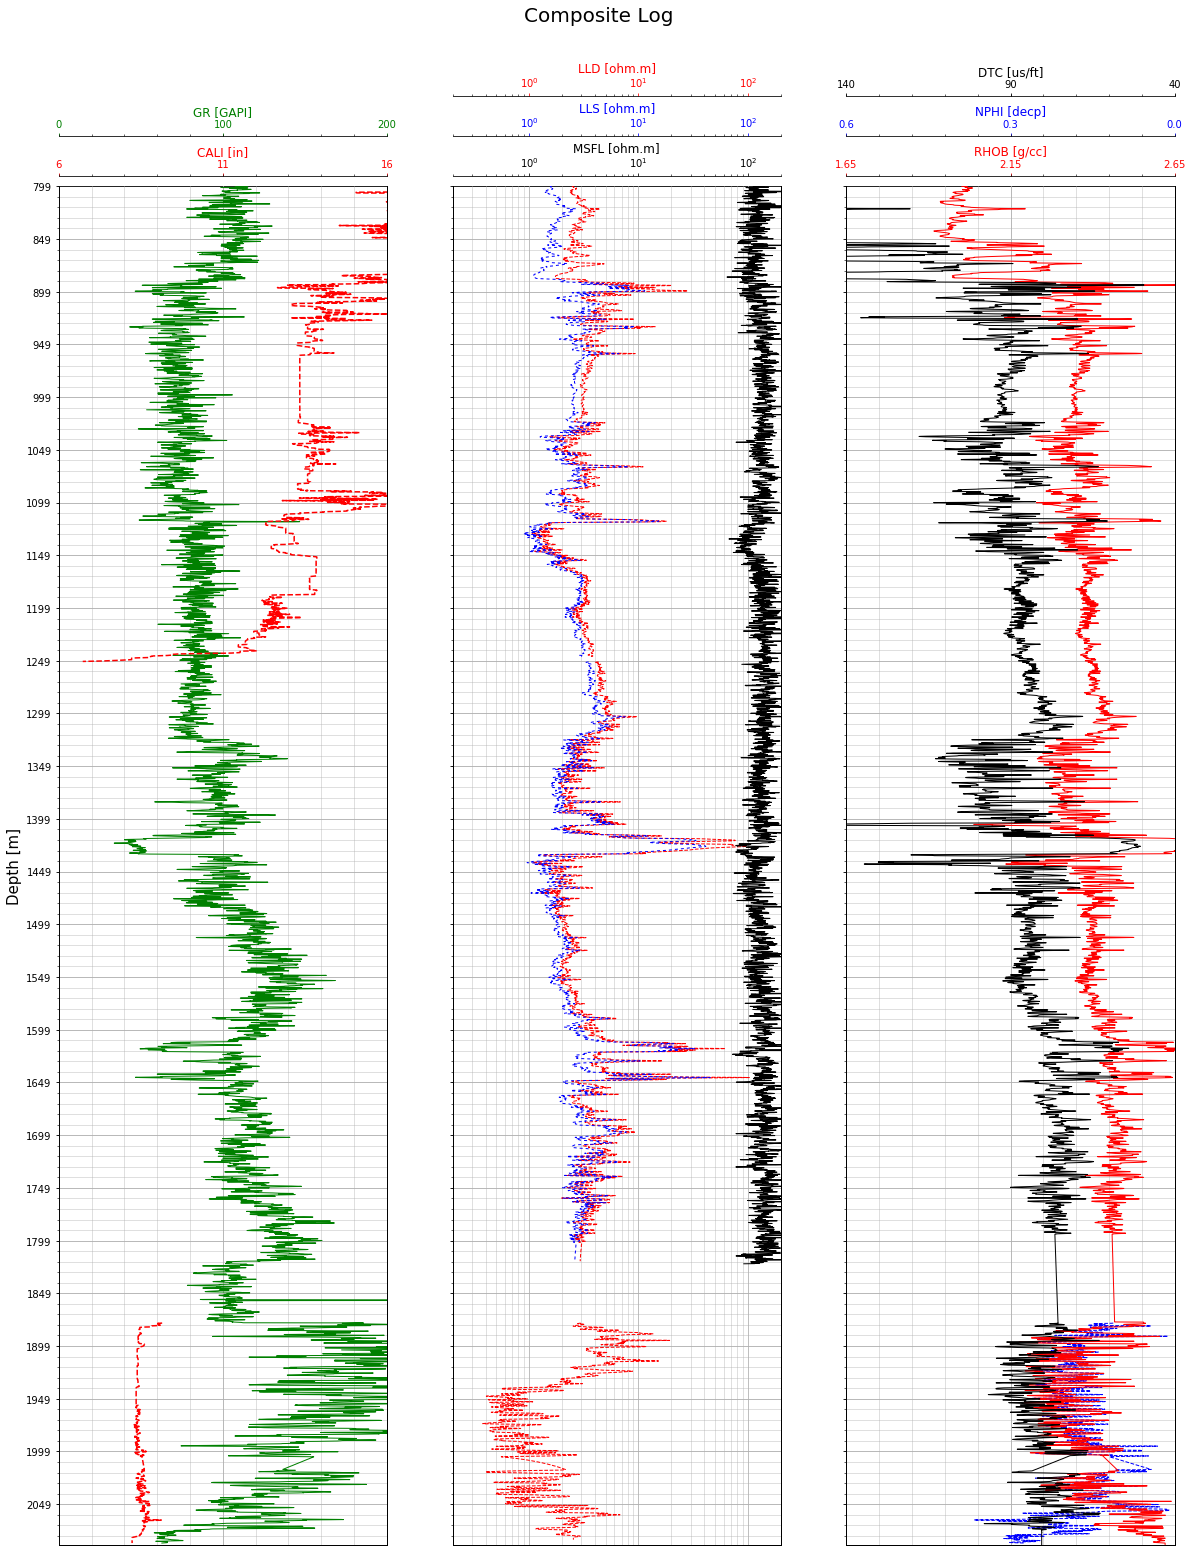

In [190]:
top = las_df_well_2['DEPTH'].min()
bottom = las_df_well_2['DEPTH'].max()

wireline_log_plotting(top,bottom,las_df_well_2)

From the plot we can see that: <br>
no MSFL and LLS curve after around 1820 mMD (which is suspected to be reservoir zone) <br>
no NPHI in the upper zone

In [192]:
las_df_well_2_TC = las_df_well_2_TC[['DEPTH','GR','NPHI','RHOB','DTC','LLD']]
las_df_well_2_TC.index = pd.RangeIndex(len(las_df_well_2_TC.index))

las_df_well_2_TC.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD
0,798.6139,109.049,NaN,2.0012,174.471,2.4615
1,798.7663,107.666,NaN,2.0055,172.980,2.4923
2,798.9187,107.890,NaN,2.0096,171.564,2.5163
3,799.0711,112.576,NaN,2.0171,169.038,2.5545
4,799.2235,115.341,NaN,2.0190,168.396,2.5597


In [194]:
#load RCAL data

df_rcal_well_2 = pd.read_csv('./data/well_2_rcal.csv')
df_rcal_well_2

,DEPTH (m),HE POR,KH,KV,Shift,1.1,Unnamed: 6
0,1885.02,13.8,1.40,20.00,1886.12,NaN,NaN
1,1885.25,14.4,5.90,NaN,1886.35,NaN,NaN
2,1885.50,9.3,0.14,NaN,1886.60,NaN,NaN
3,1885.76,12.5,0.18,NaN,1886.86,NaN,NaN
4,1886.02,12.4,0.37,0.03,1887.12,NaN,NaN
...,...,...,...,...,...,...,...
3966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3969,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [343]:
#create dataframe for scaled data
df_scaled_well_2 = scaling_features(las_df_well_2_TC)
df_scaled_well_2.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,798.6139,0.210526,NaN,0.102477,0.791153,0.020336,NaN,NaN
1,798.7663,0.206656,NaN,0.107674,0.781723,0.020637,NaN,NaN
2,798.9187,0.207283,NaN,0.112628,0.772769,0.020871,NaN,NaN
3,799.0711,0.220397,NaN,0.121692,0.756794,0.021244,NaN,NaN
4,799.2235,0.228135,NaN,0.123988,0.752734,0.021294,NaN,NaN


In [204]:
# Add core data to the dataframe
las_df_well_2_TC_core = shift_core_depth(
                                            las_df_well_2_TC,
                                            df_rcal_well_2,
                                            col_name='KH',
                                            depth_rcal='Shift',
                                            depth='DEPTH'
                                        )
las_df_well_2_TC_core.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,798.6139,109.049,NaN,2.0012,174.471,2.4615,NaN,NaN
1,798.7663,107.666,NaN,2.0055,172.980,2.4923,NaN,NaN
2,798.9187,107.890,NaN,2.0096,171.564,2.5163,NaN,NaN
3,799.0711,112.576,NaN,2.0171,169.038,2.5545,NaN,NaN
4,799.2235,115.341,NaN,2.0190,168.396,2.5597,NaN,NaN


In [205]:
# Add core data to the dataframe
las_df_well_2_TC_core = shift_core_depth(
                                            las_df_well_2_TC_core,
                                            df_rcal_well_2,
                                            col_name='HE POR',
                                            depth_rcal='Shift',
                                            depth='DEPTH'
                                        )
las_df_well_2_TC_core.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,798.6139,109.049,NaN,2.0012,174.471,2.4615,NaN,NaN
1,798.7663,107.666,NaN,2.0055,172.980,2.4923,NaN,NaN
2,798.9187,107.890,NaN,2.0096,171.564,2.5163,NaN,NaN
3,799.0711,112.576,NaN,2.0171,169.038,2.5545,NaN,NaN
4,799.2235,115.341,NaN,2.0190,168.396,2.5597,NaN,NaN


We will select the lower part of the log which is supposed to be the reservoir zone

In [206]:
las_df_well_2_TC_core = las_df_well_2_TC_core.loc[las_df_well_2_TC_core['DEPTH']>1880].dropna()
las_df_well_2_TC_core.index = pd.RangeIndex(len(las_df_well_2_TC_core.index))
las_df_well_2_TC_core.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,1886.1403,177.375,0.1580,2.4193,75.8117,10.2281,1.40,13.8
1,1886.4451,162.800,0.1539,2.4679,79.0125,10.4848,5.90,14.4
2,1886.9023,167.644,0.1606,2.5263,79.0704,12.5748,0.18,12.5
3,1887.2071,166.093,0.1480,2.5153,77.5949,13.5280,0.37,12.4
4,1887.3595,155.248,0.1067,2.5177,77.6811,12.1009,49.00,11.5


In [207]:
#save the dataframe
las_df_well_2_TC_core.to_csv('las_df_well_2_TC_core.csv')

Use the trained model to predict KH and HE POR <br>
We will compare with data from RCAL

In [356]:
test_X_df_2 = las_df_well_2_TC_core.drop(['DEPTH','HE POR','KH'],axis=1)
test_X_df_2

,GR,NPHI,RHOB,DTC,LLD
0,177.375,0.1580,2.4193,75.8117,10.2281
1,162.800,0.1539,2.4679,79.0125,10.4848
2,167.644,0.1606,2.5263,79.0704,12.5748
3,166.093,0.1480,2.5153,77.5949,13.5280
4,155.248,0.1067,2.5177,77.6811,12.1009
...,...,...,...,...,...
151,185.863,0.1739,2.3257,85.8084,0.6958
152,168.891,0.1651,2.3066,74.6443,0.9145
153,167.699,0.2224,2.2167,89.1595,0.4355
154,211.222,0.2050,2.2800,85.7968,0.5714


In [416]:
scaler = MinMaxScaler()
df_temp = las_df_well_2_TC_core
df_scaled_well_2 = pd.DataFrame(scaler.fit_transform(las_df_well_2_TC_core), columns=las_df_well_2_TC_core.columns)
df_scaled_well_2['DEPTH'] = df_temp['DEPTH']
df_scaled_well_2['HE POR'] = df_temp['HE POR']
df_scaled_well_2['KH'] = df_temp['KH']
df_scaled_well_2

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR,cluster
0,1886.1403,0.407028,0.556996,0.613057,0.347405,0.538946,1.40,13.8,0.5
1,1886.4451,0.310425,0.538668,0.742038,0.446950,0.553032,5.90,14.4,0.5
2,1886.9023,0.342531,0.568619,0.897028,0.448750,0.667724,0.18,12.5,0.5
3,1887.2071,0.332251,0.512293,0.867834,0.402862,0.720032,0.37,12.4,0.5
4,1887.3595,0.260370,0.327671,0.874204,0.405543,0.641718,49.00,11.5,0.5
...,...,...,...,...,...,...,...,...,...
151,1950.9103,0.463287,0.628073,0.364650,0.658302,0.015848,153.00,18.2,1.0
152,1951.6723,0.350796,0.588735,0.313960,0.311099,0.027850,1.20,16.6,1.0
153,1952.1295,0.342895,0.844882,0.075372,0.762521,0.001564,1.40,13.4,1.0
154,1953.1963,0.631368,0.767099,0.243365,0.657941,0.009022,116.00,18.2,1.0


In [345]:
test_X_df_2 = df_scaled_well_2.drop(['DEPTH','HE POR','KH'],axis=1)
test_X_df_2

,GR,NPHI,RHOB,DTC,LLD
0,0.407028,0.556996,0.613057,0.347405,0.538946
1,0.310425,0.538668,0.742038,0.446950,0.553032
2,0.342531,0.568619,0.897028,0.448750,0.667724
3,0.332251,0.512293,0.867834,0.402862,0.720032
4,0.260370,0.327671,0.874204,0.405543,0.641718
...,...,...,...,...,...
151,0.463287,0.628073,0.364650,0.658302,0.015848
152,0.350796,0.588735,0.313960,0.311099,0.027850
153,0.342895,0.844882,0.075372,0.762521,0.001564
154,0.631368,0.767099,0.243365,0.657941,0.009022


In [357]:
# test_y_df_2 = las_df_well_2_TC_core[['HE POR','KH']]
test_y_df_2 = las_df_well_2_TC_core[['HE POR']]

In [346]:
test_y_df_2 = df_scaled_well_2[['HE POR']]
test_y_df_2

,HE POR
0,13.8
1,14.4
2,12.5
3,12.4
4,11.5
...,...
151,18.2
152,16.6
153,13.4
154,18.2


In [358]:
y_pred_well_2 = model.predict(test_X_df_2.to_numpy())

In [359]:
model.evaluate(test_X_df_2.to_numpy(),test_y_df_2.to_numpy())

156/156 [==============================] - 0s 51us/sample - loss: 45.4711


45.47114073924529

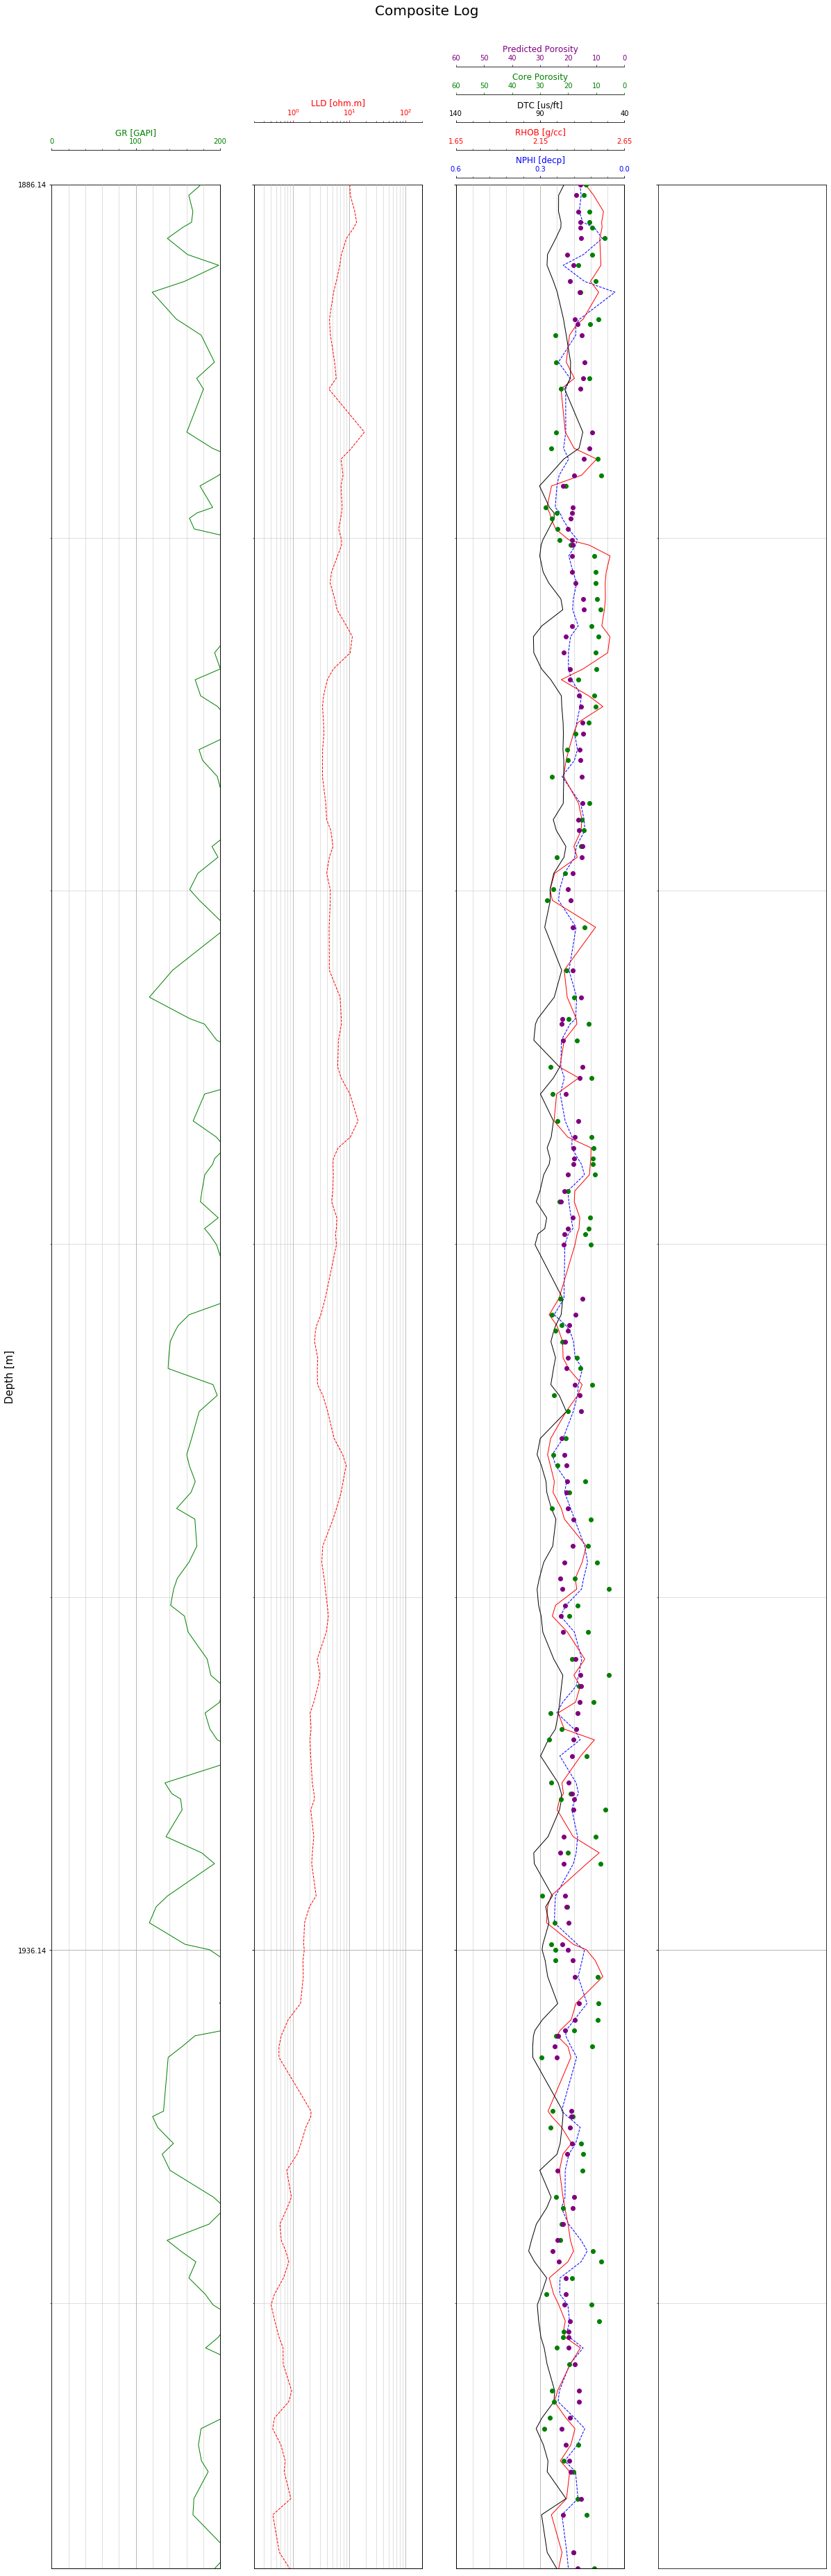

In [360]:
plot_rcal(las_df_well_2_TC_core,y_pred_well_2,las_df_well_2_TC_core['DEPTH'])

<h1> Part 4 </h1>
<h2> Clustering on the second well </h2>

In [397]:
def clustering_depth(df,n_clusters):
    #run the K-means clustering

    kmeans = KMeans(n_clusters=n_clusters)
    k_means = kmeans.fit(df)
    labels = k_means.labels_

    #save the clustering results in the new column
    df['cluster']=k_means.labels_
    return df

In [417]:
df_scaled_well_2 = clustering_depth(df_scaled_well_2.drop(['KH','HE POR','DEPTH','cluster'],axis=1),n_clusters=3)
df_scaled_well_2.head()

,GR,NPHI,RHOB,DTC,LLD,cluster
0,0.407028,0.556996,0.613057,0.347405,0.538946,1
1,0.310425,0.538668,0.742038,0.446950,0.553032,1
2,0.342531,0.568619,0.897028,0.448750,0.667724,1
3,0.332251,0.512293,0.867834,0.402862,0.720032,1
4,0.260370,0.327671,0.874204,0.405543,0.641718,1


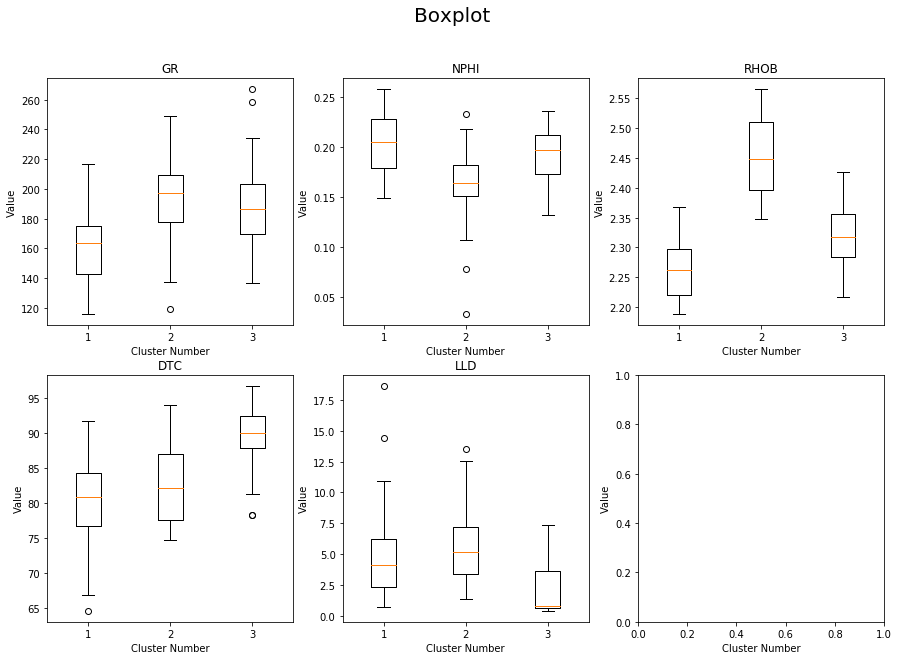

In [418]:
#Add cluster column to the unscaled dataframe
las_df_well_2_TC_core['cluster'] = df_scaled_well_2['cluster']
las_df_well_2_TC_core.head()

cluster_boxplot(las_df_well_2_TC_core,3)

In [400]:
df_facies_well_2 = pd.read_csv('./data/well_2_facies.csv')
df_facies_well_2.head()

,Top Depth (mBRT),Bottom Depth (mBRT),Facies
0,1877.61,1894.0,1
1,1894.00,1895.0,2
2,1895.00,1896.0,1
3,1896.00,1901.0,2
4,1901.00,1906.0,1


KeyError: 'MSFL'

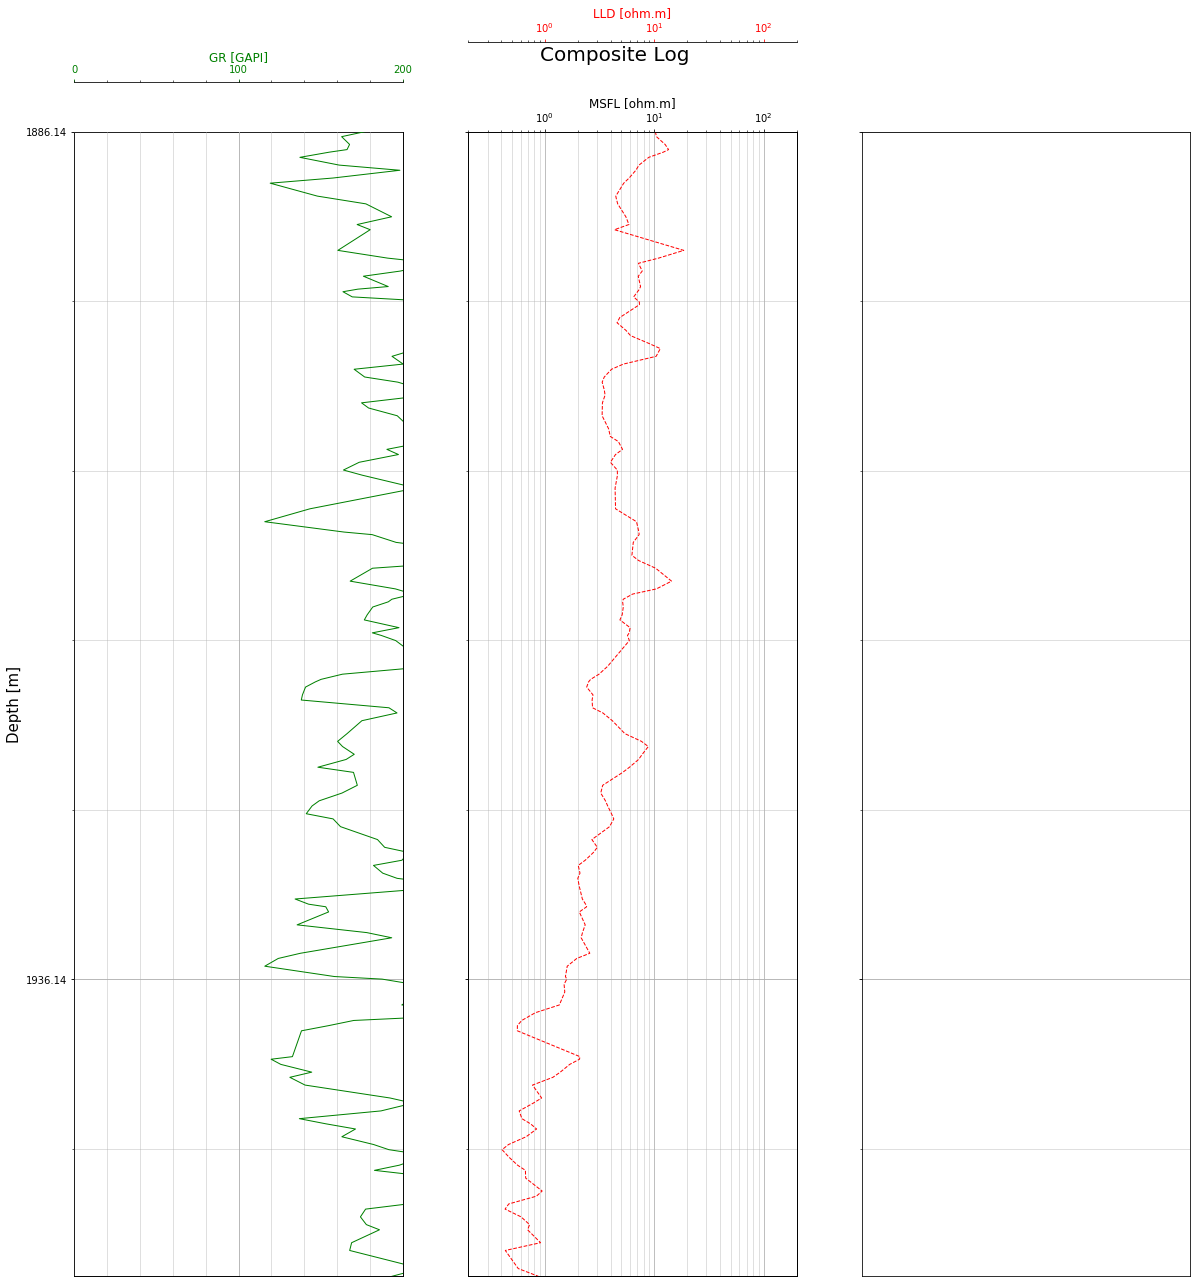

In [421]:
def plot_facies(df,df_facies):
    '''
    Plot facies identified by geologist compared with clustering results
    '''
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,20),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.92)

    top = df['DEPTH'].min()
    bottom = df['DEPTH'].max()
    
    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False) 
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(df['GR'],df['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)


    #Track 2: Resistivity
    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(df['LLD'],df['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

    #MSFL
    ax_MSFL=ax[1].twiny()
    ax_MSFL.set_xscale('log')
    ax_MSFL.set_xlim(0.2,200)
    ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
    ax_MSFL.plot(las_df_well_2_TC['MSFL'],las_df_well_2_TC['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
    ax_MSFL.spines['top'].set_position(('outward',10))

    
    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #FACIES FROM CLUSTERING
    ax_fc=ax[2].twiny()
    ax_fc.set_xlim(0,4)
    ax_fc.set_xlabel('Facies from Clustering',color="Brown",fontsize=12)
    ax_fc.step(df['cluster']+1,df['DEPTH'],color="Brown",label='Cluster',linewidth=2)
    ax_fc.tick_params(axis='x', colors='Brown')
    ax_fc.spines['top'].set_position(('outward',130))

    #FACIES FROM GEOLOGIST
    ax_fc2=ax[2].twiny()
    ax_fc2.set_xlim(0,4)
    ax_fc2.set_xlabel('Facies from Geologist',color="Blue",fontsize=12)
    ax_fc2.step(df_facies['Facies'],df_facies['Top Depth (mBRT)'],color="Blue",label='Facies',linewidth=1)
    ax_fc2.tick_params(axis='x', colors='Blue')
    ax_fc2.spines['top'].set_position(('outward',170))

plot_facies(las_df_well_2_TC_core,df_facies_well_2)